# RQ 2: How does sentiment correlate with topic, social metrics and demographic variables?

## Resources

In [3]:
# Get Packages & Libraries
library(brms)
library(bayesplot)
library(rethinking)
library(tidyverse)
#library(tidybayes)
library(ggplot2)
library(ggridges)
#library(viridis)
library(stargazer)
#library(cowplot)
library(patchwork)
library(gghighlight)

In [4]:
# Functions
factorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "character")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

dbl2fact <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "numeric")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

int2fact <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "integer")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

numerize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "character")) # that looks for variables with the character class 
      df[[i]] = as.numeric(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

#unfactorize <- function(df){ # Create a function
#  for(i in which(sapply(df, class) == "factor")) # that looks for variables with the character class 
#      df[[i]] = as.character(df[[i]]) # and converts them to factor (i.e., categorical) class
#  return(df)
#}

st <- function(x){
    (x-mean(x,na.rm=TRUE))/sd(x,na.rm=TRUE)
}


In [5]:
# Settings
options(scipen=999)

In [6]:
# Get Data
# View Data
df  <- read.csv("20250318_PhD_LtrChk-RQ1a.csv")
#df[df == ''] <- NA #replace blank cells with NA
df <- factorize(df)
glimpse(df)
#colnames(df)
#sum(is.na(df))

Rows: 2,392
Columns: 42
$ docID.AT         <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ docid            <fct> 20910, 21062, 21062, 21324, 21334, 21334, 21354, 2135…
$ docyear          <int> 1891, 1871, 1871, 1892, 1891, 1891, 1890, 1890, 1800,…
$ docmonth         <int> 7, 11, 11, 5, 10, 10, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1…
$ authorName       <fct> Isabella Weir Moore, E. Rothwell, E. Rothwell, Isabel…
$ docauthorid      <fct> IED0107, IED0179, IED0179, IED0107, IED0621, IED0621,…
$ authorLocation   <fct> USA, Canada, Canada, USA, USA, USA, USA, USA, USA, US…
$ authorGender     <fct> F, F, F, F, F, F, M, M, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> Irish, Irish, Irish, Irish, Irish, Irish, Irish, Iris…
$ irish            <fct> True, True, True, True, True, True, True, True, True,…
$ otherUK          <fct> False, False, False, False, False, False, False, Fals…
$ relMin           <fct> NA, NA, NA, NA, False, False, NA, NA, NA, NA, NA, NA,…
$ catholic      

## Multilevel (partial pooling) model with simple random intercepts

$$CompoundSentiment_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$
$$\alpha_k \sim \mathrm{Normal}(\gamma, \phi) $$ 
$$\gamma \sim \mathrm{Normal}(0,.2) $$ 
$$\phi \sim \mathrm{Uniform}(0,.3) $$
$$\sigma \sim \mathrm{Uniform}(0,.3)$$ 

In [21]:
f5pp <- readRDS("20250319_PhD_LtrChkScoCom-pp.rds")

#f5pp <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + (1 | docauthorid),
#            prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3)), #sigma
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20250319_PhD_LtrChkScoCom-pp",
#           control=list(adapt_delta=.99))

print(f5pp, prob = .90)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + (1 | docauthorid) 
   Data: df (Number of observations: 2392) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-90% CI u-90% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.14      0.01     0.11     0.16 1.00     1271     2132

Regression Coefficients:
          Estimate Est.Error l-90% CI u-90% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.17      0.01     0.15     0.19 1.00     1751     2379

Further Distributional Parameters:
      Estimate Est.Error l-90% CI u-90% CI Rhat Bulk_ESS Tail_ESS
sigma     0.27      0.00     0.26     0.28 1.00     5027     2323

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at converg

Before we add narrative predictors, we will integrate the demographic and temporal data this corpus affords. To do this, we need to adjust the notation to allow for greater complexity. Instead of $\alpha_k$ for the intercept, we now use $\beta_{0k}$ as shown below. 

<h4>Multilevel (partial pooling) model with group (i.e., author) level predictors on the random intercepts</h4>

$$scoreCompound_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k}$$

$$\beta_{0k} = \gamma_{00} + \gamma_{01}Irish_k + \gamma_{02}Female_k + \eta_{0k}$$ 
$$\eta_{0k} \sim \mathrm{Normal}(0,\phi_0) $$ 
$$\sigma \sim \mathrm{Uniform}(0,.3)$$ 
$$\gamma_{00} \sim \mathrm{Normal}(0,.2)$$
$$\gamma_{01}, \gamma_{02} \sim \mathrm{Normal}(0,.2)$$
$$\phi_0 \sim \mathrm{Uniform}(0,.3) $$

soci620_22_twoLevelModels

In [7]:
# First prepare the variables

# Check Counts
df%>% 
distinct(docauthorid, authorName, authorGender, irish) %>%
arrange(docauthorid)%>%
summary()

# Create New Variables
df$Female <- 0 # Male (Base)
df$Female[df$authorGender=="F"] <- 1 #Female
df$Irish <- 0 # Other UK (Base)
df$Irish[df$irish=="True"] <- 1 #Irish

#Check Counts
df %>%
distinct(docauthorid, authorName, Female, Irish)%>%
arrange(docauthorid)%>%
dbl2fact()%>%
summary()

  docauthorid              authorName  authorGender   irish   
 IED0028:  1   Ada C. Burns     :  1   F:79         False:80  
 IED0030:  1   Ada C. Edgar     :  1   M:95         True :94  
 IED0032:  1   Ada M. Demain    :  1                          
 IED0037:  1   Agnes Shakespeare:  1                          
 IED0068:  1   Alexander Robb   :  1                          
 IED0069:  1   (Other)          :136                          
 (Other):168   NA's             : 33                          

  docauthorid              authorName  Female Irish 
 IED0028:  1   Ada C. Burns     :  1   0:95   0:80  
 IED0030:  1   Ada C. Edgar     :  1   1:79   1:94  
 IED0032:  1   Ada M. Demain    :  1                
 IED0037:  1   Agnes Shakespeare:  1                
 IED0068:  1   Alexander Robb   :  1                
 IED0069:  1   (Other)          :136                
 (Other):168   NA's             : 33                

In [16]:
#get_prior(data = df, formula = scoreCom ~ 1 + Female + Irish + (1 | docauthorid))

f5ppFI <- readRDS("20250324_PhD_LtrChkScoCom-ppFI.rds")

#f5ppFI <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + Female + Irish + (1 | docauthorid),
#            prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
#                    set_prior("normal(0,.2)",class='b')), # effect of Female and Irish
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20250324_PhD_LtrChkScoCom-ppFI",
#           control=list(adapt_delta=.99))

#prior_summary(f5ppFI)
#posterior_summary(f5ppFI, probs = c(.05, .95))[1:5,] #90% CI
#posterior_summary(f5ppFI, probs = c(.15, .85))[1:5,] #70% CI
print(f5ppFI)

#20190321_PM_Code.htm

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + Female + Irish + (1 | docauthorid) 
   Data: df (Number of observations: 2392) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.11      0.01     0.09     0.14 1.00     1270     1856

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.09      0.02     0.05     0.12 1.00     2557     2958
Female       -0.01      0.03    -0.06     0.05 1.00     1436     2061
Irish         0.15      0.03     0.10     0.21 1.00     1536     2216

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.27      0.00     0.26     0.28 1.00     5208     2709

Draws were sampled using sampling(NUTS

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.06812  0.08520  0.14538  0.16802  0.23687  0.48468 

[1] 0.1061304

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9200  0.0600  0.1450  0.1773  0.2800  0.9700 

[1] 16

[1] 13

[1] 0.1091954

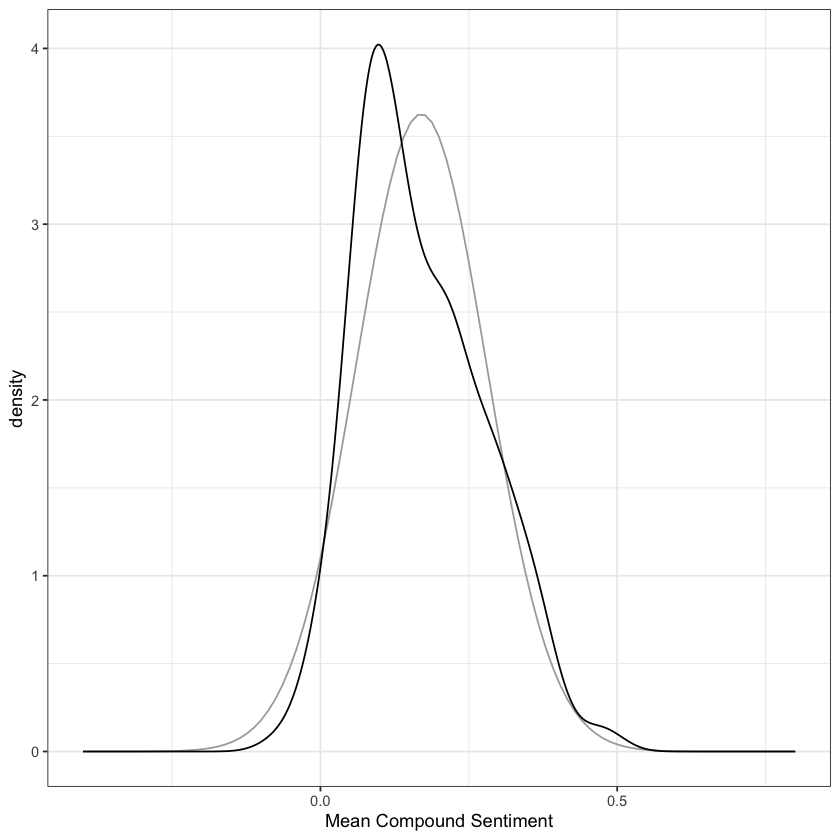

In [122]:
nd <- df %>% distinct(docauthorid, Female, Irish) %>% arrange(docauthorid)

f <- data.frame(fitted(f5ppFI,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

summary(f$Estimate)
sd(f$Estimate)

p <- f %>% ggplot(aes(x = Estimate)) + 
   xlim(-.4, .8) + 
   stat_function(fun = dnorm, args = list(mean = .17, sd = .11), colour = "darkgrey") + 
geom_density()+
xlab("Mean Compound Sentiment")+
theme_bw()
p

#What are the author means from the original dataset?
authorMeans <- df %>% 
select(docauthorid, scoreCom) %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
pull(mean)
summary(authorMeans)
#dens(authorMeans)
#sd(authorMeans)

#How many means below the lowest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean < -0.06812) %>%
nrow()

#How many means above the highest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean > 0.48468) %>%
nrow()

19/174


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.17951 -0.03773  0.16574  0.16740  0.37132  1.56996 

[1] 0.3026863

[1] 0.003301724

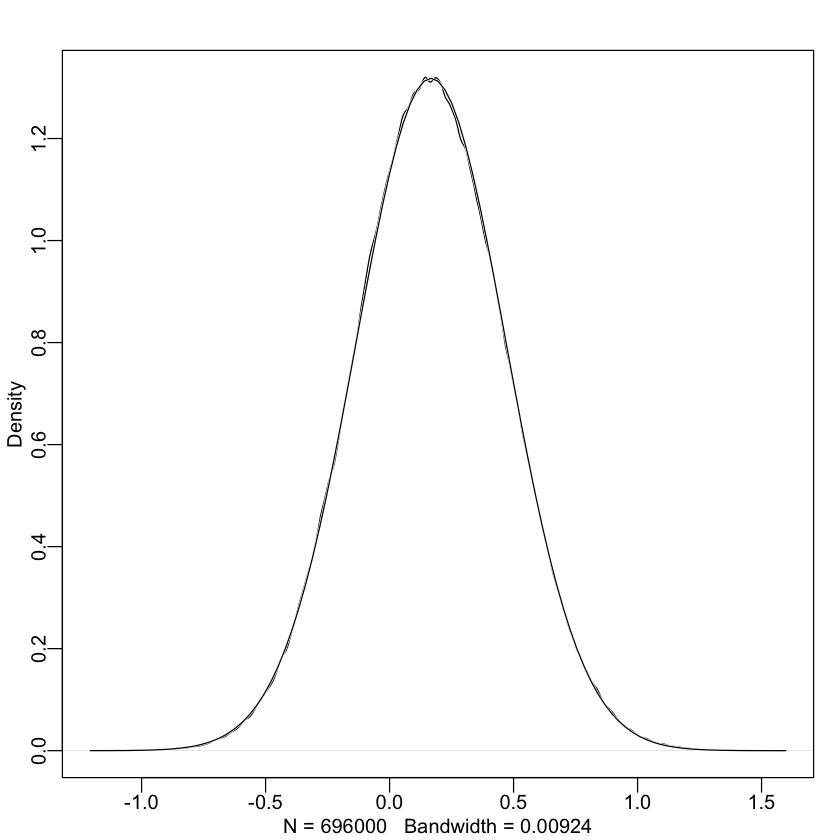

In [123]:
set.seed(5)

posteriorCheck <- data.frame(predict(f5ppFI,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

predictions <- posteriorCheck %>% gather(variable, value) %>% pull(value)

summary(predictions)
sd(predictions)

(sum(predictions > 1) / length(predictions)) + (sum(predictions < -1) / length(predictions))

dens(predictions, norm.comp = TRUE)

<h4>Multilevel (partial pooling) model with case (i.e., text) level controls</h4>

$$CompoundSentiment_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} + \beta_1Year + \beta_2Month + \beta_3Place$$

$$\beta_{0k} = \gamma_{0} + \eta_{0k}$$ 
$$\beta_1, \beta_2, \beta_3 \sim \mathrm{Normal}(0,.2)$$
$$\eta_{0k} \sim \mathrm{Normal}(0,\phi_0) $$ 
$$\sigma \sim \mathrm{Uniform}(0,.3)$$ 
$$\gamma_{0} \sim \mathrm{Normal}(0,.2)$$
$$\phi_0 \sim \mathrm{Uniform}(0,.3) $$

20190228_PM_Slides.pdf<br>
soci620_22_twoLevelModels

In [8]:
df%>% 
distinct(docauthorid, authorName, authorLocation) %>%
group_by(docauthorid)%>%
#filter(n()>1)#%>%
arrange(docauthorid)%>%
summary()

# Checking to make sure authors are correctly assigned to two countries. All good. The authors were traveling.
#df%>%
#filter(docauthorid == "IED0125" | docauthorid == "per0029184") %>%
#select(docauthorid, authorName, docid, authorLocation, docyear,docmonth)

df$Canada <- 0 # USA (Base)
df$Canada[df$authorLocation=="Canada"] <- 1 #Canada

df %>%
distinct(docauthorid, authorName, Canada)%>%
arrange(docauthorid)%>%
dbl2fact() %>%
summary()

     docauthorid              authorName  authorLocation
 IED0125   :  2   Caledon          :  2   Canada: 56    
 per0029184:  2   Ada C. Burns     :  1   USA   :120    
 IED0028   :  1   Ada C. Edgar     :  1                 
 IED0030   :  1   Ada M. Demain    :  1                 
 IED0032   :  1   Agnes Shakespeare:  1                 
 IED0037   :  1   (Other)          :136                 
 (Other)   :168   NA's             : 34                 

     docauthorid              authorName  Canada 
 IED0125   :  2   Caledon          :  2   0:120  
 per0029184:  2   Ada C. Burns     :  1   1: 56  
 IED0028   :  1   Ada C. Edgar     :  1          
 IED0030   :  1   Ada M. Demain    :  1          
 IED0032   :  1   Agnes Shakespeare:  1          
 IED0037   :  1   (Other)          :136          
 (Other)   :168   NA's             : 34          

In [9]:
summary(df$docyear)
df$lateCentury[df$docyear<=1869] <- 0
df$lateCentury[df$docyear>=1870] <- 1
table(as.factor(df$lateCentury))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1770    1834    1858    1856    1871    1912 


   0    1 
1708  684 

In [24]:
#get_prior(data = df, formula = scoreCom ~ 1 + year.s + Canada + (1 | docauthorid))

f5ppLC <- readRDS("20250324_PhD_LtrChkScoCom-ppLC.rds")

#f5ppLC <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + lateCentury + Canada +  (1 | docauthorid),
#            prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
#                    set_prior("normal(0,.2)",class='b')), # effect of late century and Canada
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20250324_PhD_LtrChkScoCom-ppLC",
#           control=list(adapt_delta=.99))

#prior_summary(f5ppLC)
#posterior_summary(f5ppLC, probs = c(.05, .95))[1:5,] #90% CI
#posterior_summary(f5ppLC, probs = c(.15, .85))[1:5,] #70% CI
print(f5ppLC)

#20190321_PM_Code.htm

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + lateCentury + Canada + (1 | docauthorid) 
   Data: df (Number of observations: 2392) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.13      0.01     0.11     0.16 1.00     1047     2124

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       0.15      0.02     0.11     0.19 1.00     1568     2079
lateCentury     0.06      0.02     0.02     0.10 1.00     2604     2650
Canada          0.01      0.03    -0.05     0.07 1.00     1306     1831

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.27      0.00     0.26     0.28 1.00     4149     2623

Draws were sampled using

In [10]:
#nrow(df)-2364
#sum(is.na(df$docmonth))
df<-df[!is.na(df$docmonth),]
#length(unique(df$docauthorid))

In [11]:
df%>%filter(docmonth=="1"| docmonth=="2" | docmonth=="7" | docmonth=="8")%>%nrow()

df$lowMonths <- 0
#df$peakMonth[is.na(df$docmonth)] <- NA # Coding NAs as not October on probabilistic grounds.
df$lowMonths[df$docmonth == 1] <- 1
df$lowMonths[df$docmonth == 2] <- 1
df$lowMonths[df$docmonth == 7] <- 1
df$lowMonths[df$docmonth == 8] <- 1

summary(as.factor(df$lowMonths))

[1] 795

0    1 
1569  795

In [28]:
f5ppLClMs <- readRDS("20250324_PhD_LtrChkScoCom-ppLClMs.rds")

#f5ppLClMs <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + lateCentury + Canada + lowMonths + (1 | docauthorid),
#            prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
#                    set_prior("normal(0,.2)",class='b')), # effect of predictors
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20250324_PhD_LtrChkScoCom-ppLClMs",
#          control=list(adapt_delta=.99))

#prior_summary(f5ppLClMs)
print(f5ppLClMs)
#posterior_summary(f5ppLClMs, probs = c(.05, .95))[1:6,] #90% CI
#posterior_summary(f5ppLClMs, probs = c(.15, .85))[1:6,] #70% CI

#20190321_PM_Code.htm

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + lateCentury + Canada + lowMonths + (1 | docauthorid) 
   Data: df (Number of observations: 2364) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.14      0.01     0.11     0.17 1.00     1027     1431

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       0.16      0.02     0.13     0.20 1.00     2279     2676
lateCentury     0.06      0.02     0.03     0.10 1.00     3500     2935
Canada          0.02      0.03    -0.04     0.07 1.00     1423     1953
lowMonths      -0.05      0.01    -0.08    -0.02 1.00     5641     3470

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma  

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.0600  0.1200  0.1700  0.1791  0.2400  0.4900 

[1] 0.09598804

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9200  0.0600  0.1450  0.1773  0.2800  0.9700 

[1] 16

[1] 13

[1] 0.1666667

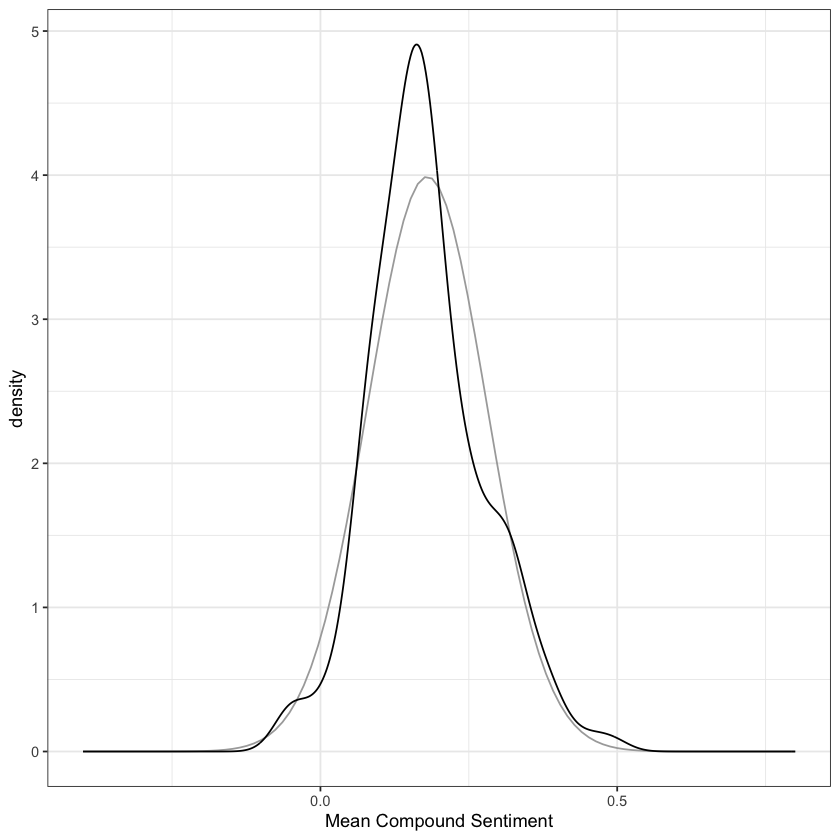

In [119]:
set.seed(5)

docids <- df %>% distinct(docauthorid) %>% pull()
docids <- rep(docids, 8) %>% sort()
docids <- docids %>% data.frame() %>% rename(docauthorid = 1)
temps <- expand_grid(lateCentury = 0:1, Canada = 0:1, lowMonths = 0:1) %>% data.frame()
nd <- cbind(docids, temps)

f <- data.frame(fitted(f5ppLClMs,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

p <- f %>% 
cbind(nd) %>% 
select(docauthorid, Estimate) %>% 
group_by(docauthorid) %>% 
summarize(Estimate = round(mean(Estimate), digits = 2))
summary(p$Estimate)
sd(p$Estimate)

p1 <- p %>% ggplot(aes(x = Estimate)) + 
   xlim(-.4, .8) + 
   stat_function(fun = dnorm, args = list(mean = .18, sd = .1), colour = "darkgrey") + 
geom_density()+
xlab("Mean Compound Sentiment")+
theme_bw()
p1

#What are the author means from the original dataset?
authorMeans <- df %>% 
select(docauthorid, scoreCom) %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
pull(mean)
summary(authorMeans)
#dens(authorMeans)
#sd(authorMeans)

#How many means below the lowest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean < -0.0600) %>%
nrow()

#How many means above the highest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean > 0.4900) %>%
nrow()

29/174

#ggsave("20250313_PhD_CsPp-RandomMeansAll.jpg")

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.26736 -0.02662  0.17817  0.17910  0.38376  1.78415 

[1] 0.3043872

[1] 0.00379472

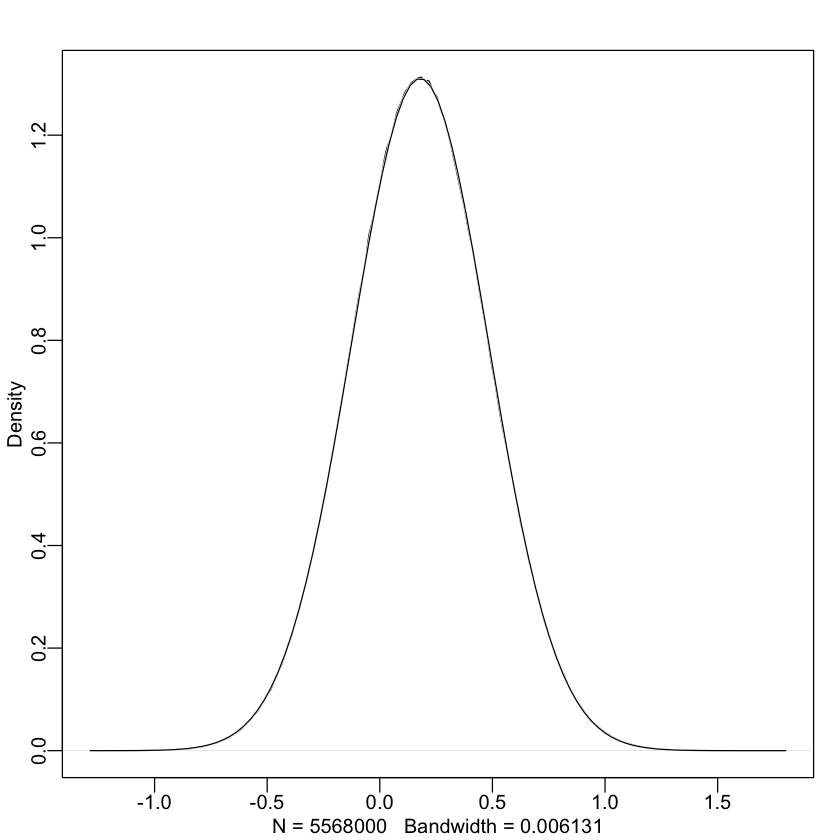

In [120]:
set.seed(5)

posteriorCheck <- data.frame(predict(f5ppLClMs,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

predictions <- posteriorCheck %>% gather(variable, value) %>% pull(value)

summary(predictions)
sd(predictions)

(sum(predictions > 1) / length(predictions)) + (sum(predictions < -1) / length(predictions))

dens(predictions, norm.comp = TRUE)

## Re-run base model on subset for model comparison.

In [244]:
f5ppS <- readRDS("20250330_PhD_LtrChkScoCom-ppS.rds")

#f5ppS <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + (1 | docauthorid),
#            prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3)), #sigma
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20250330_PhD_LtrChkScoCom-ppS",
#           control=list(adapt_delta=.99))

print(f5ppS)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + (1 | docauthorid) 
   Data: df (Number of observations: 2364) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.14      0.01     0.11     0.17 1.00     1212     1941

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.17      0.01     0.14     0.20 1.00     1666     2189

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.27      0.00     0.26     0.28 1.00     6829     2770

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at converg

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.0650  0.1124  0.1596  0.1719  0.2165  0.5165 

[1] 0.09786339

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9200  0.0600  0.1450  0.1773  0.2800  0.9700 

[1] 16

[1] 13

[1] 0.1666667

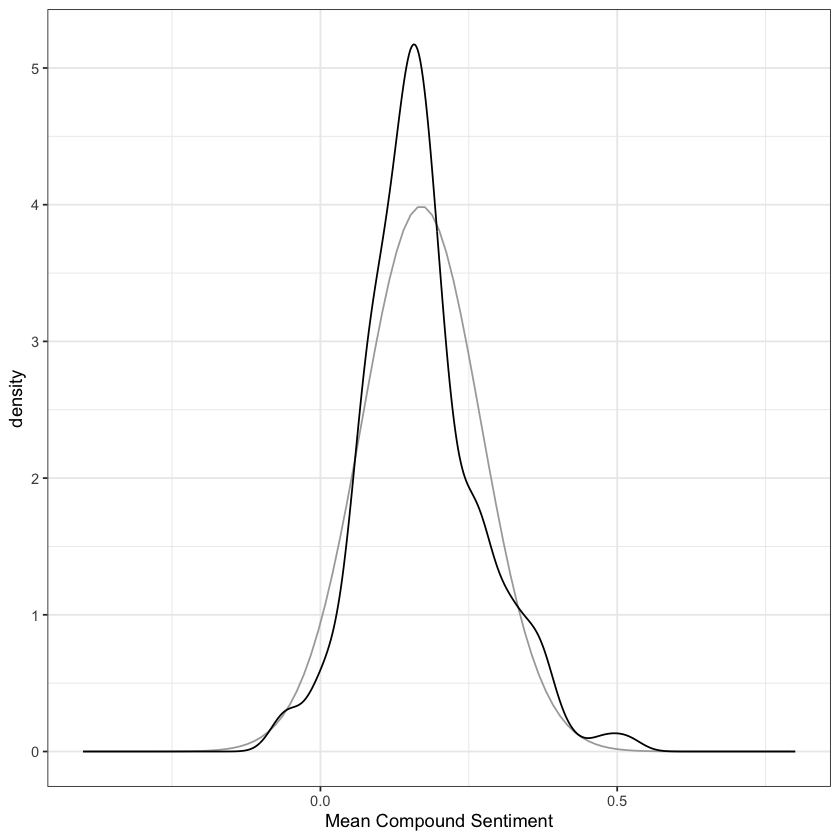

In [116]:
set.seed(5)

nd <- df %>% distinct(docauthorid)

f <- data.frame(fitted(f5ppS,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))
summary(f$Estimate)
sd(f$Estimate)

p <- f %>% ggplot(aes(x = Estimate)) + 
   xlim(-.4, .8) + 
   stat_function(fun = dnorm, args = list(mean = .17, sd = .1), colour = "darkgrey") + 
geom_density()+
xlab("Mean Compound Sentiment")+
theme_bw()
p

#What are the author means from the original dataset?
authorMeans <- df %>% 
select(docauthorid, scoreCom) %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
pull(mean)
summary(authorMeans)
#dens(authorMeans)
#sd(authorMeans)

#How many means below the lowest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean < -0.0650) %>%
nrow()

#How many means above the highest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean > 0.5165) %>%
nrow()

29/174

#ggsave("20250313_PhD_CsPp-RandomMeansAll.jpg")

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.25035 -0.03341  0.16972  0.17124  0.37481  1.59252 

[1] 0.3029457

[1] 0.003556034

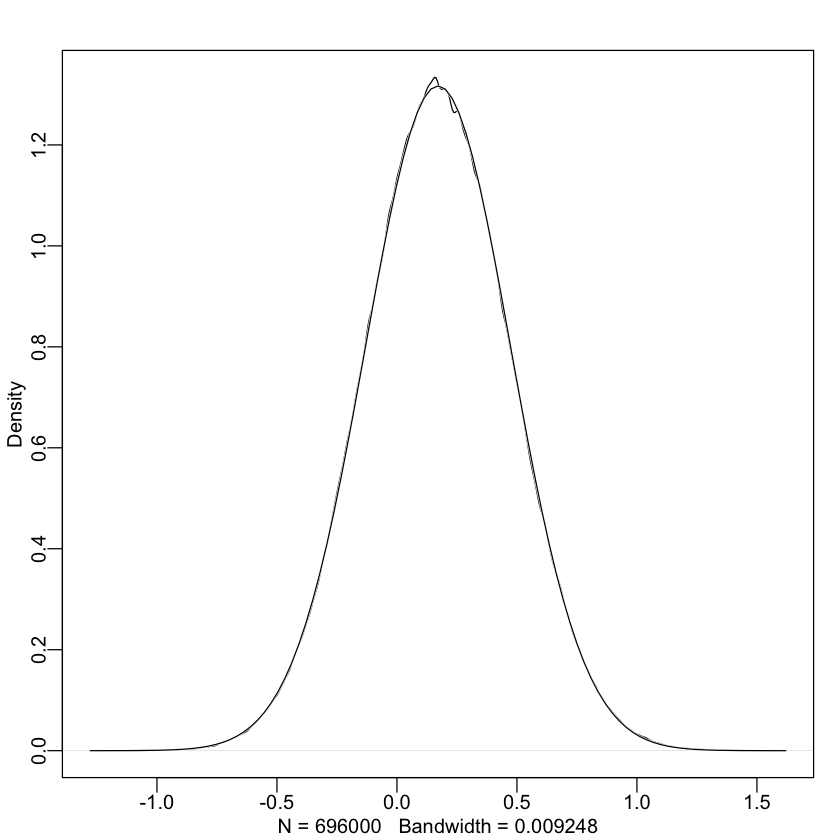

In [117]:
set.seed(5)

posteriorCheck <- data.frame(predict(f5ppS,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

predictions <- posteriorCheck %>% gather(variable, value) %>% pull(value)

summary(predictions)
sd(predictions)

(sum(predictions > 1) / length(predictions)) + (sum(predictions < -1) / length(predictions))

dens(predictions, norm.comp = TRUE)

## Re-Run Model with Author Level Variables

In [56]:
#get_prior(data = df, formula = scoreCom ~ 1 + Female + Irish + (1 | docauthorid))

f5ppFIS <- readRDS("20250324_PhD_LtrChkScoCom-ppFIS.rds")

#f5ppFIS <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + Female + Irish + (1 | docauthorid),
#           prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
#                    set_prior("normal(0,.2)",class='b')), # effect of Female and Irish
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20250324_PhD_LtrChkScoCom-ppFIS",
#           control=list(adapt_delta=.99))

#prior_summary(f5ppFIS)
#posterior_summary(f5ppFIS, probs = c(.05, .95))[1:5,] #90% CI
#posterior_summary(f5ppFIS, probs = c(.15, .85))[1:5,] #70% CI
print(f5ppFIS)

#20190321_PM_Code.htm

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + Female + Irish + (1 | docauthorid) 
   Data: df (Number of observations: 2364) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.11      0.01     0.09     0.14 1.00     1332     2695

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.09      0.02     0.05     0.13 1.00     2407     2843
Female       -0.01      0.03    -0.06     0.05 1.00     1379     1889
Irish         0.15      0.03     0.09     0.21 1.00     1779     2486

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.27      0.00     0.26     0.28 1.00     4210     2786

Draws were sampled using sampling(NUTS

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.06837  0.08643  0.14626  0.16781  0.23490  0.48480 

[1] 0.1053514

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9200  0.0600  0.1450  0.1773  0.2800  0.9700 

[1] 16

[1] 13

[1] 0.1091954

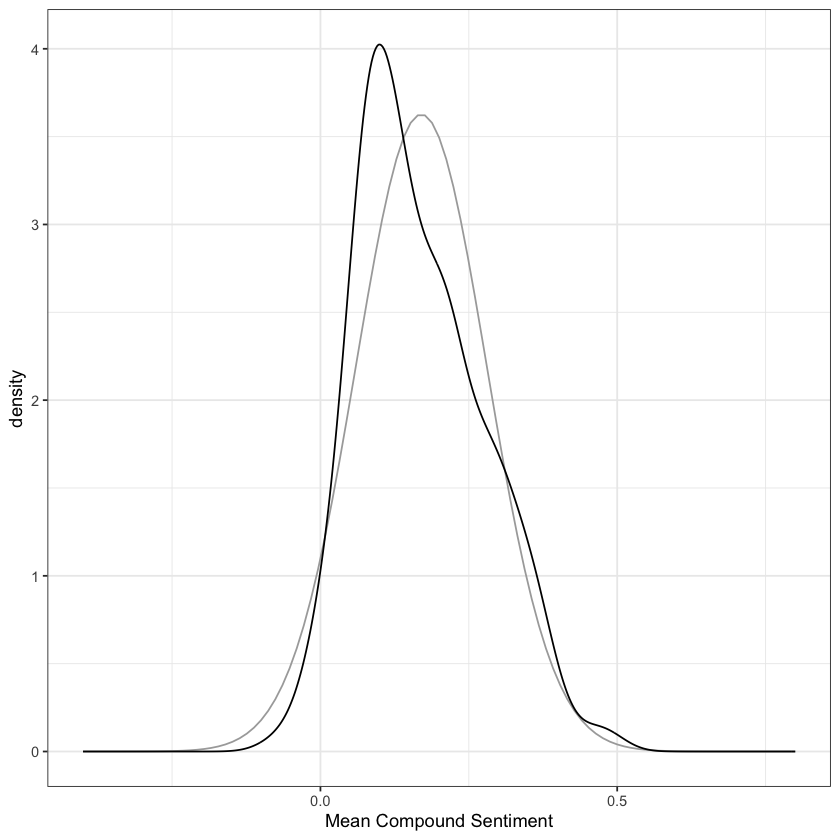

In [114]:
nd <- df %>% distinct(docauthorid, Female, Irish) %>% arrange(docauthorid)

f <- data.frame(fitted(f5ppFIS,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

summary(f$Estimate)
sd(f$Estimate)

p <- f %>% ggplot(aes(x = Estimate)) + 
   xlim(-.4, .8) + 
   stat_function(fun = dnorm, args = list(mean = .17, sd = .11), colour = "darkgrey") + 
geom_density()+
xlab("Mean Compound Sentiment")+
theme_bw()
p

#What are the author means from the original dataset?
authorMeans <- df %>% 
select(docauthorid, scoreCom) %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
pull(mean)
summary(authorMeans)
#dens(authorMeans)
#sd(authorMeans)

#How many means below the lowest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean < -0.06837) %>%
nrow()

#How many means above the highest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean > 0.48480) %>%
nrow()

19/174


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.22807 -0.03787  0.16545  0.16720  0.37065  1.66251 

[1] 0.3028121

[1] 0.00328592

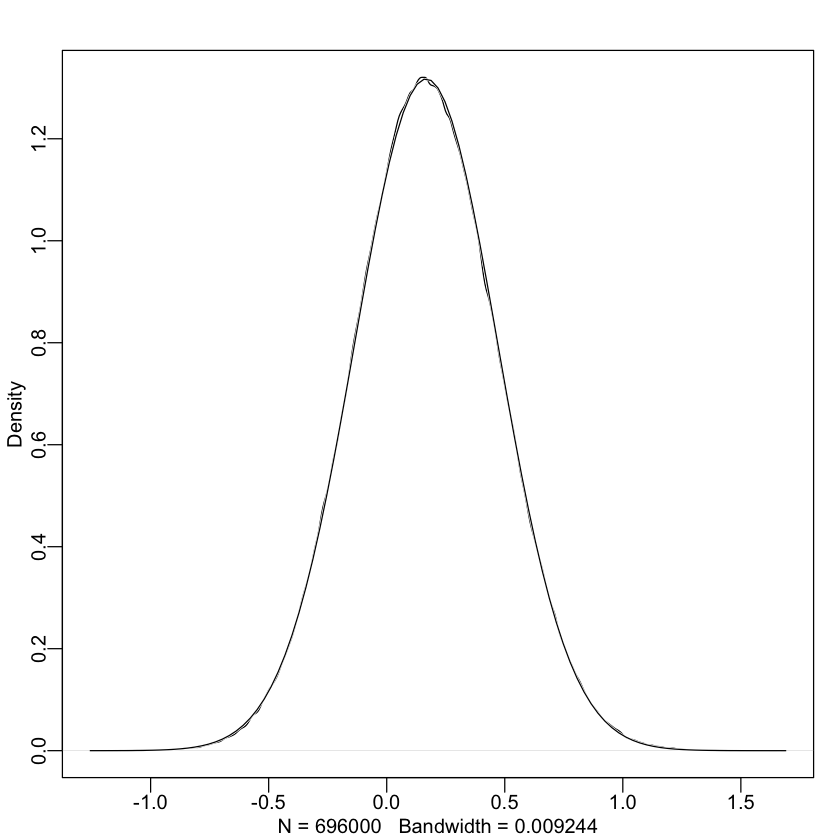

In [115]:
set.seed(5)

posteriorCheck <- data.frame(predict(f5ppFIS,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

predictions <- posteriorCheck %>% gather(variable, value) %>% pull(value)

summary(predictions)
sd(predictions)

(sum(predictions > 1) / length(predictions)) + (sum(predictions < -1) / length(predictions))

dens(predictions, norm.comp = TRUE)

## Re-Run Model with Text Level Variables

In [61]:
f5ppLCS <- readRDS("20250324_PhD_LtrChkScoCom-ppLCS.rds")

#f5ppLCS <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + lateCentury + Canada +  (1 | docauthorid),
#            prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
#                    set_prior("normal(0,.2)",class='b')), # effect of late century and Canada
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20250324_PhD_LtrChkScoCom-ppLCS",
#           control=list(adapt_delta=.99))

#prior_summary(f5ppLCS)
#posterior_summary(f5ppLCS, probs = c(.05, .95))[1:5,] #90% CI
#posterior_summary(f5ppLCS, probs = c(.15, .85))[1:5,] #70% CI
print(f5ppLCS)

#20190321_PM_Code.htm

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + lateCentury + Canada + (1 | docauthorid) 
   Data: df (Number of observations: 2364) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.13      0.01     0.11     0.16 1.01     1121     2192

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       0.15      0.02     0.12     0.18 1.00     1673     2566
lateCentury     0.06      0.02     0.02     0.10 1.00     2675     3014
Canada          0.02      0.03    -0.04     0.07 1.00     1124     1912

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.27      0.00     0.26     0.28 1.00     4832     2730

Draws were sampled using

For info about this error message, see 6.5.1.1 in https://bookdown.org/ajkurz/Statistical_Rethinking_recoded/overfitting-regularization-and-information-criteria.html and https://cran.r-project.org/web/packages/loo/vignettes/loo2-example.html#computing-psis-loo-and-checking-diagnostics

## All Author and Text Level Variables (Random Intercepts Only)

$$CompoundSentiment_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} + \beta_{1}Year_i + \beta_{2}Month_i + \beta_{3}Place_i $$

$$\beta_{0k} = \gamma_{0} + \gamma_{1}Origin_k + \gamma_{2}Gender_k + \eta_{0k}$$ 
$$\gamma_{0},...,\gamma_{2} \sim \mathrm{Normal}(0,.2)$$
$$\eta_{0k} \sim \mathrm{Normal}(0,\phi_0) $$ 
$$\beta_{1}, \beta_{2}, \beta_{3} \sim \mathrm{Normal}(0,.2)$$
$$\sigma \sim \mathrm{Uniform}(0,.3)$$ 
$$\phi_0 \sim \mathrm{Uniform}(0,.3) $$

20190228_PM_Slides.pdf<br>soci620_19_randomIntercepts.pdf

In [254]:
#f5ppSFILClMs <- readRDS("20250330_PhD_LtrChkScoCom-ppSFILClMs.rds")

f5ppSFILClMs <- brm(data=df,
            family = 'gaussian',
            formula = scoreCom ~ 1 + Female + Irish + lateCentury + Canada + lowMonths + (1 | docauthorid),
            prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
                    set_prior("normal(0,.2)",class='b')), # effect of predictors
            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
            file = "20250330_PhD_LtrChkScoCom-ppSFILClMs",
           control=list(adapt_delta=.99))

#prior_summary(f5ppSFILClMs)
print(f5ppSFILClMs)
#posterior_summary(f5ppSFILClMs, probs = c(.05, .95))[1:6,] #90% CI
#posterior_summary(f5ppSFILClMs, probs = c(.15, .85))[1:6,] #70% CI

#20190321_PM_Code.htm

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + Female + Irish + lateCentury + Canada + lowMonths + (1 | docauthorid) 
   Data: df (Number of observations: 2364) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.12      0.01     0.09     0.14 1.00     1508     2413

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       0.09      0.02     0.04     0.14 1.00     4013     3586
Female         -0.01      0.03    -0.07     0.05 1.00     2160     2907
Irish           0.14      0.03     0.08     0.20 1.00     2455     3102
lateCentury     0.04      0.02     0.00     0.07 1.00     5661     3430
Canada          0.03      0.03    -0.02     0.09 1.00     2307     2683
lowMonths      -0.05

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.0500  0.1000  0.1500  0.1734  0.2400  0.4800 

[1] 0.1039378

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9200  0.0600  0.1450  0.1773  0.2800  0.9700 

[1] 17

[1] 13

[1] 0.1724138

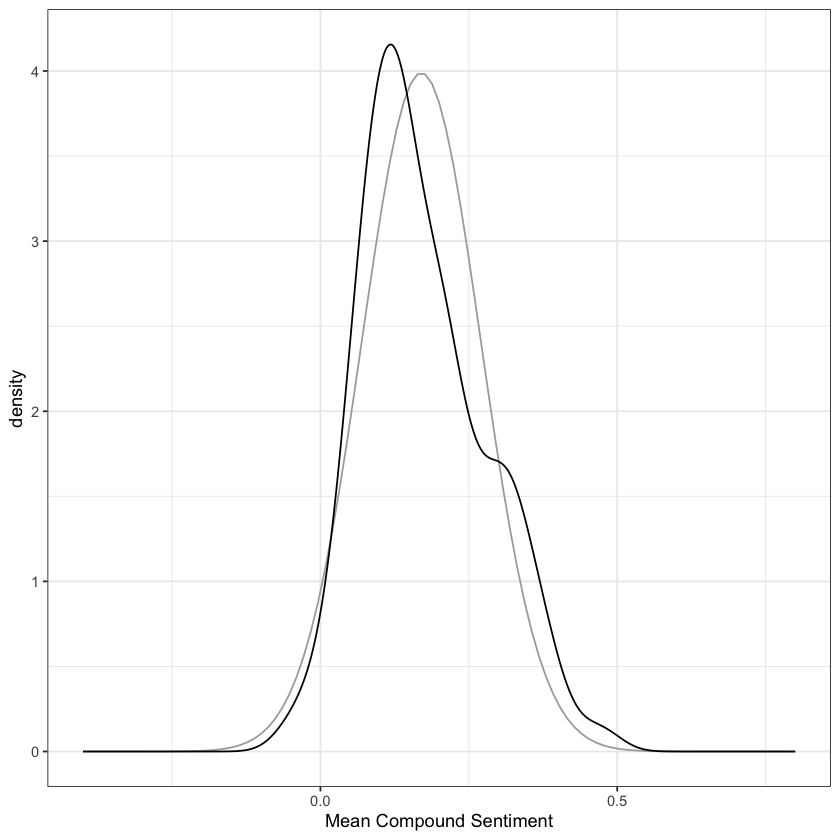

In [112]:
set.seed(5)

docids <- df %>% distinct(docauthorid, Female, Irish) %>% slice(rep(1:n(), each = 8)) %>% arrange(docauthorid)
temps <- expand_grid(lateCentury = 0:1, Canada = 0:1, lowMonths = 0:1) %>% data.frame()
nd <- cbind(docids, temps)

f <- data.frame(fitted(f5ppSFILClMs,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

p <- f %>% 
cbind(nd) %>% 
select(docauthorid, Estimate) %>% 
group_by(docauthorid) %>% 
summarize(Estimate = round(mean(Estimate), digits = 2))
summary(p$Estimate)
sd(p$Estimate)


p1 <- p %>% ggplot(aes(x = Estimate)) + 
   xlim(-.4, .8) + 
   stat_function(fun = dnorm, args = list(mean = .17, sd = .1), colour = "darkgrey") + 
geom_density()+
xlab("Mean Compound Sentiment")+
theme_bw()
p1

#What are the author means from the original dataset?
authorMeans <- df %>% 
select(docauthorid, scoreCom) %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
pull(mean)
summary(authorMeans)
#dens(authorMeans)
#sd(authorMeans)

#How many means below the lowest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean < -0.0500) %>%
nrow()

#How many means above the highest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean > 0.4800) %>%
nrow()

30/174

#ggsave("20250313_PhD_CsPp-RandomMeansAll.jpg")

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.34592 -0.03244  0.17199  0.17334  0.37767  1.85721 

[1] 0.3039289

[1] 0.003568247

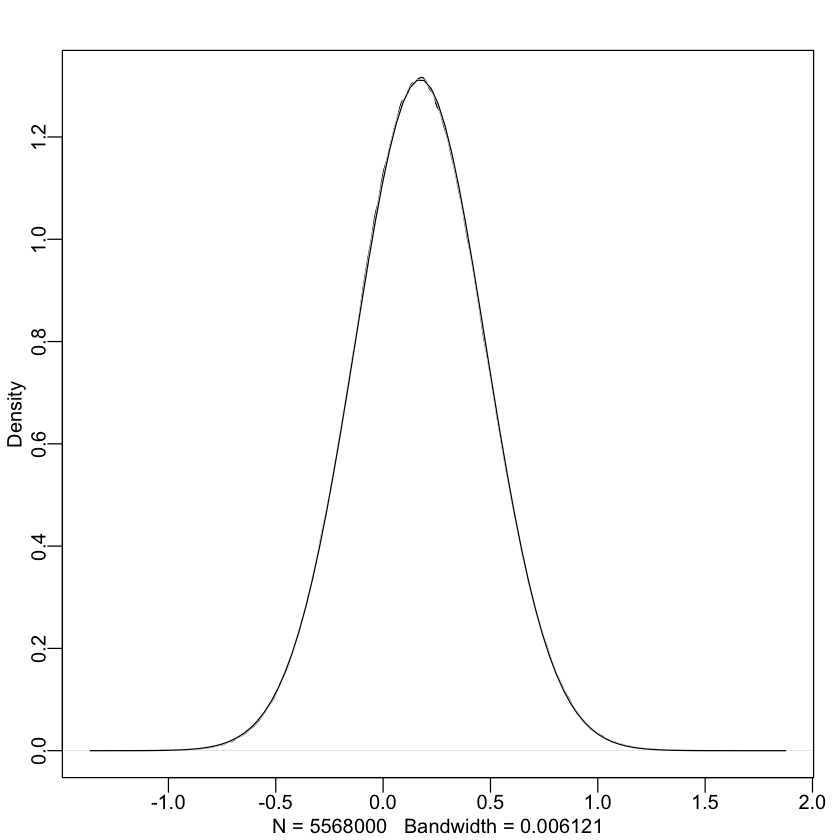

In [113]:
set.seed(5)

posteriorCheck <- data.frame(predict(f5ppSFILClMs,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

predictions <- posteriorCheck %>% gather(variable, value) %>% pull(value)

summary(predictions)
sd(predictions)

(sum(predictions > 1) / length(predictions)) + (sum(predictions < -1) / length(predictions))

dens(predictions, norm.comp = TRUE)

## All Author and Text Level Variables (Random Intercepts and Random Slopes)

$$CompoundSentiment_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} + \beta_{1k}Year_i + \beta_{2k}Month_i + \beta_{3k}Place_i $$

$$\beta_{0k} = \gamma_{00} + \gamma_{01}Origin_k + \gamma_{02}Gender_k + \eta_{0k}$$ 
$$\beta_{1k} = \gamma_{10} + \eta_{1k}$$
$$\beta_{2k} = \gamma_{20} + \eta_{2k}$$
$$\beta_{3k} = \gamma_{30} + \eta_{3k}$$
$$\gamma_{00},..., \gamma_{30} \sim \mathrm{Normal}(0,.2)$$
$$\sigma \sim \mathrm{Uniform}(0,.3)$$ 

$$\left[ \begin{split}\eta_{0k} \\ \eta_{1k} \\ \eta_{2k} \\ \eta_{3k}\end{split} \right] \sim \mathrm{MVNormal}\left(\left[ \begin{split}0 \\ 0\\ 0 \\ 0 \end{split} \right], \Phi R \Phi\right)$$

$$\Phi = \begin{bmatrix}\phi_0&0&0&0 \\ 0&\phi_1&0&0 \\ 0&0&\phi_2&0 \\ 0&0&0&\phi_3 \end{bmatrix}$$

$$\mathrm{R} = \begin{bmatrix}1&\rho_{01}&\rho_{02}&\rho_{03}\\ {\color{grey}\rho_{\color{grey}{01}}}&1&\rho_{12}&\rho_{13}\\ {\color{grey}\rho_{\color{grey}{02}}}& {\color{grey}\rho_{\color{grey}{12}}}&1&\rho_{23}\\  {\color{grey}\rho_{\color{grey}{03}}}&{\color{grey}\rho_{\color{grey}{13}}}&{\color{grey}\rho_{\color{grey}{23}}}&1\end{bmatrix}$$

$$\phi_0, \phi_1, \phi_2, \phi_3 \sim \mathrm{Uniform}(0,.3) $$
$$R \sim \mathrm{LKJ}(2)$$


20190228_PM_Slides.pdf<br>soci620_19_randomIntercepts.pdf

In [120]:
#get_prior(data=df, family = 'gaussian', formula = scoreCom ~ 1 + Female + Irish + lateCentury + Canada + lowMonths + (1 + lateCentury + Canada + lowMonths | docauthorid))

f5ppSFILClMsIS <- readRDS("20250331_PhD_LtrChkScoCom-ppSFILClMsIS.rds")

#f5ppSFILClMsIS <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + Female + Irish + lateCentury + Canada + lowMonths + 
#(1 + lateCentury + Canada + lowMonths | docauthorid),
#                    prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
#                    set_prior("normal(0,.2)",class='b'), #sigma
#                    set_prior("lkj(2)", class = "cor")), # effect of predictors
#            iter=2500, warmup = 1500, chains=4, cores=4, seed = 4,
#            file = "20250331_PhD_LtrChkScoCom-ppSFILClMsIS",
#          control=list(adapt_delta=.99))

#prior_summary(f5ppSFILClMsIS)
print(f5ppSFILClMsIS)
#posterior_summary(f5ppSFILClMsIS, probs = c(.05, .95))[1:6,] #90% CI
#posterior_summary(f5ppSFILClMsIS, probs = c(.15, .85))[1:6,] #70% CI

#20190321_PM_Code.htm

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + Female + Irish + lateCentury + Canada + lowMonths + (1 + lateCentury + Canada + lowMonths | docauthorid) 
   Data: df (Number of observations: 2364) 
  Draws: 4 chains, each with iter = 2500; warmup = 1500; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                  0.10      0.02     0.07     0.13 1.00     1729
sd(lateCentury)                0.18      0.05     0.09     0.27 1.01      606
sd(Canada)                     0.05      0.04     0.00     0.14 1.00      491
sd(lowMonths)                  0.16      0.03     0.11     0.22 1.00     1339
cor(Intercept,lateCentury)    -0.03      0.31    -0.60     0.60 1.01      450
cor(Intercept,Canada)         -0.22      0.36    -0.79     0.52 1.00     1199
cor(lateCentury,Canada)        0.10      0.36

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.0400  0.1000  0.1400  0.1606  0.2200  0.4500 

[1] 0.08657058

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9200  0.0600  0.1450  0.1773  0.2800  0.9700 

[1] 18

[1] 16

[1] 0.1954023

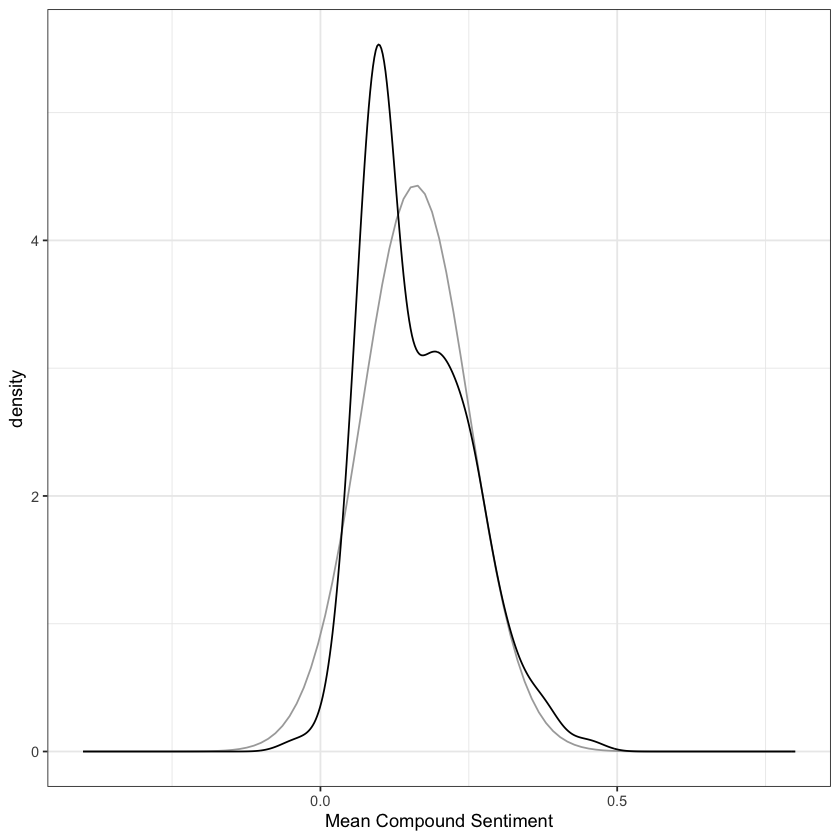

In [101]:
set.seed(5)

docids <- df %>% distinct(docauthorid, Female, Irish) %>% slice(rep(1:n(), each = 8)) %>% arrange(docauthorid)
temps <- expand_grid(lateCentury = 0:1, Canada = 0:1, lowMonths = 0:1) %>% data.frame()
nd <- cbind(docids, temps)

f <- data.frame(fitted(f5ppSFILClMsIS,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

p <- f %>% 
cbind(nd) %>% 
select(docauthorid, Estimate) %>% 
group_by(docauthorid) %>% 
summarize(Estimate = round(mean(Estimate), digits = 2))
summary(p$Estimate)
sd(p$Estimate)

p1 <- p %>% ggplot(aes(x = Estimate)) + 
   xlim(-.4, .8) + 
   stat_function(fun = dnorm, args = list(mean = .16, sd = .09), colour = "darkgrey") + 
geom_density()+
xlab("Mean Compound Sentiment")+
theme_bw()
p1

#What are the author means from the original dataset?
authorMeans <- df %>% 
select(docauthorid, scoreCom) %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
pull(mean)
summary(authorMeans)
#dens(authorMeans)
#sd(authorMeans)

#How many means below the lowest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean < -0.0400) %>%
nrow()

#How many means above the highest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean > 0.4500) %>%
nrow()

34/174

#ggsave("20250313_PhD_CsPp-RandomMeansAll.jpg")

In [107]:
# Posterior Predictive Check

posteriorCheck <- predict(f5ppSFILClMsIS, prob=.90, summary = F) %>% data.frame() %>% gather(variable, value) %>% pull(value)
summary(posteriorCheck)
(sum(posteriorCheck > 1) / length(posteriorCheck)) + (sum(posteriorCheck < -1) / length(posteriorCheck))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.35857 -0.05523  0.13814  0.14248  0.33550  1.80221 

[1] 0.002665503

In [82]:
# Compare Models
f5ppS_i <- add_criterion(f5ppS, "waic")
f5ppSFILClMs_i <- add_criterion(f5ppSFILClMs, "waic")
f5ppSFILClMsIS_i <- add_criterion(f5ppSFILClMsIS, "waic")

w <- loo_compare(f5ppS_i, f5ppSFILClMs_i, f5ppSFILClMsIS_i, criterion = "waic")

print(w, simplify = F)

Warning message:
“
80 (3.4%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Automatically saving the model object in '20250330_PhD_LtrChkScoCom-ppS.rds'



                 elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic
f5ppSFILClMsIS_i    0.0       0.0  -267.1      72.1        147.8   10.3   
f5ppSFILClMs_i    -42.1      17.8  -309.1      68.6        108.3    7.7   
f5ppS_i           -55.9      19.6  -323.0      68.2        115.9    8.2   
                 waic   se_waic
f5ppSFILClMsIS_i  534.1  144.2 
f5ppSFILClMs_i    618.3  137.1 
f5ppS_i           645.9  136.4 


In [83]:
wDF <- w %>% 
as.data.frame() %>% 
mutate(model = c("Multivariate, Random Intercepts & Slopes", 
                 "Multivariate, Random Intercepts", 
                 "Univariate, Random Intercepts")) %>% 
remove_rownames() %>%
column_to_rownames("model")%>%
select(waic, elpd_diff, se_diff)%>%
rename("WAIC" = 1, "Elapsed Difference" = 2, "Standard Error" = 3)%>%
mutate(across(1:3, round, 2))

wDF
#print(round(wDF, 2))

WAIC   Elapsed Difference
Multivariate, Random Intercepts & Slopes 534.14   0.00            
Multivariate, Random Intercepts          618.27 -42.07            
Univariate, Random Intercepts            645.95 -55.91            
                                         Standard Error
Multivariate, Random Intercepts & Slopes  0.00         
Multivariate, Random Intercepts          17.83         
Univariate, Random Intercepts            19.63

In [85]:
# Compare Models
f5ppS_i <- add_criterion(f5ppS, "loo")
f5ppSFILClMsIS_i <- add_criterion(f5ppSFILClMsIS, "loo")

w <- loo_compare(f5ppS_i, f5ppSFILClMsIS_i, criterion = "loo")

print(w, simplify = F)

                 elpd_diff se_diff elpd_loo se_elpd_loo p_loo  se_p_loo looic 
f5ppSFILClMsIS_i    0.0       0.0  -270.1     72.2       150.8   10.5    540.2
f5ppS_i           -54.3      19.7  -324.3     68.3       117.2    8.4    648.7
                 se_looic
f5ppSFILClMsIS_i  144.5  
f5ppS_i           136.5  


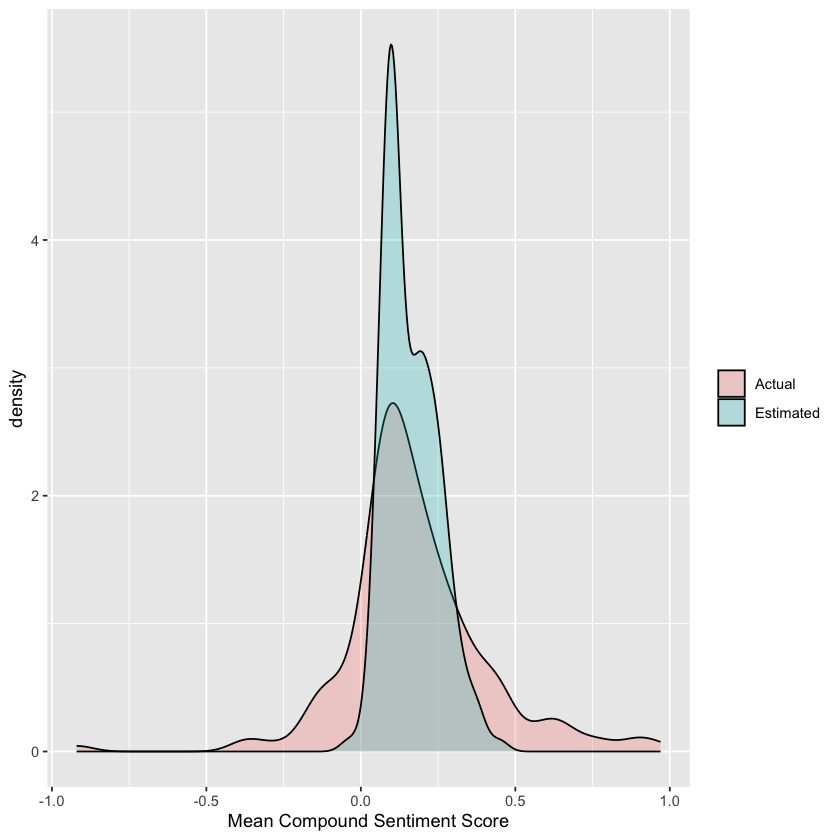

In [128]:
set.seed(5)

docids <- df %>% distinct(docauthorid, Female, Irish) %>% slice(rep(1:n(), each = 8)) %>% arrange(docauthorid)
temps <- expand_grid(lateCentury = 0:1, Canada = 0:1, lowMonths = 0:1) %>% data.frame()
nd <- cbind(docids, temps)

f <- data.frame(fitted(f5ppSFILClMsIS,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

# Estimated author means
estMeans <- f %>% 
cbind(nd) %>% 
select(docauthorid, Estimate) %>% 
group_by(docauthorid) %>%
rename("id" = 1) %>%
summarize(Estimated = round(mean(Estimate), digits = 2)) 

# Actual Author Means
actMeans <- df %>% 
group_by(docauthorid) %>% 
summarize(Actual = round(mean(scoreCom), digits = 2)) 

# Put them together 
vis <- cbind(estMeans, actMeans) %>% select(Estimated, Actual) %>% gather(variable, value)

# Plot
ggplot(vis, aes(x=value, fill=variable)) +
  geom_density(alpha=.25) +
theme(legend.title = element_blank())+
xlab("Mean Compound Sentiment Score")#+
#stat_function(fun = dnorm, args = list(mean = .16, sd = .09), colour = "darkgrey")

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.99852 -0.05563  0.15931  0.16098  0.37594  2.13076 

[1] 0.3246878

[1] 0.006364224

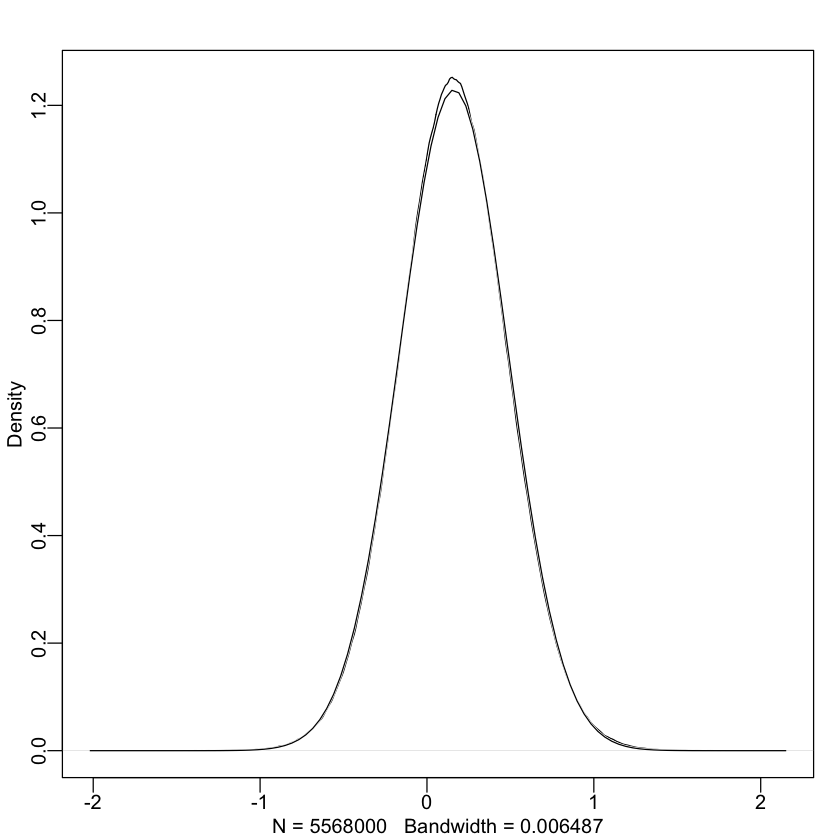

In [129]:
set.seed(5)

posteriorCheck <- data.frame(predict(f5ppSFILClMsIS,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

predictions <- posteriorCheck %>% gather(variable, value) %>% pull(value)

summary(predictions)
sd(predictions)

(sum(predictions > 1) / length(predictions)) + (sum(predictions < -1) / length(predictions))

dens(predictions, norm.comp = TRUE)

In [130]:
## Results from the Selected Model Multivariate Model with Random Intercepts and Random Slopes

In [131]:
# Fixed Effects

fe90 <- fixef(f5ppSFILClMsIS, probs = c(.05,.95))
fe70 <- fixef(f5ppSFILClMsIS, probs = c(.15,.85))

temp <- data.frame(round(fe90, digits=3))
cbind(temp, round(fe70[,3:4], digits = 3)) %>% rename(Lower90 = Q5, Upper90 = Q95, Lower70 = Q15, Upper70 = Q85)%>%
mutate(Parameter = c("Intercept", "Gender: Female", "Origin: Irish", "Year: After 1869", "Place: Canada", "Month: Jan, Feb, Jul, Aug")) %>%
remove_rownames() %>%
column_to_rownames("Parameter")%>%
mutate(across(1:6, round, 3))


Estimate Est.Error Lower90 Upper90 Lower70 Upper70
Intercept                  0.105   0.023      0.067  0.142    0.081   0.128 
Gender: Female            -0.044   0.028     -0.091  0.004   -0.072  -0.015 
Origin: Irish              0.156   0.028      0.111  0.204    0.127   0.186 
Year: After 1869           0.020   0.037     -0.040  0.081   -0.017   0.057 
Place: Canada              0.004   0.026     -0.038  0.047   -0.022   0.030 
Month: Jan, Feb, Jul, Aug -0.041   0.025     -0.082  0.002   -0.067  -0.015

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Saving 7 x 7 in image


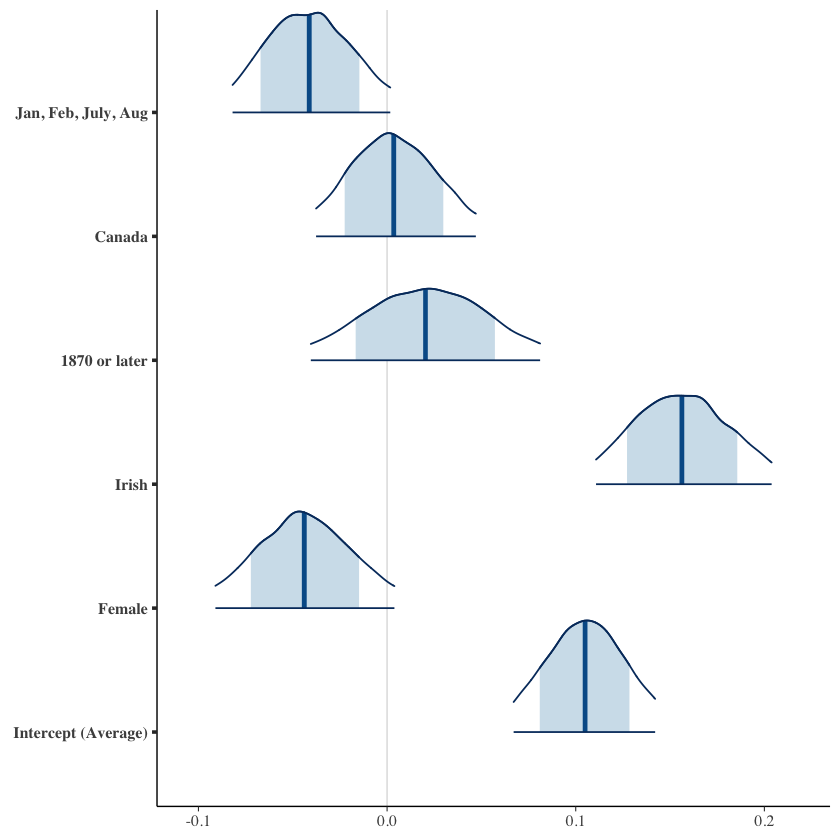

In [529]:
#mcmc_plot(f3_valTopSWB_mis, variable = "^b_", regex = TRUE, prob = 0.7, prob_outer = 0.9, outer_size = 0.5)
p <- mcmc_areas(f5ppSFILClMsIS, regex_pars = "^b_", prob = 0.7, prob_outer = 0.9, point_est = "mean")
p +
scale_y_discrete(labels=c("b_Intercept" = "Intercept (Average)", 
                          "b_lowMonths" = "Jan, Feb, July, Aug", 
                          "b_Canada" = "Canada", 
                          "b_lateCentury" = "1870 or later", 
                          "b_Female" = "Female", 
                          "b_Irish" = "Irish"))
#scale_x_continuous(breaks = seq(-.1,.3, .02))

#+  geom_vline(xintercept = -0.005	)
#ggsave("20250401_senDemTem-fixedCCs.jpg")

In [31]:
set.seed(5)

docids <- df %>% distinct(docauthorid, Female, Irish) %>% slice(rep(1:n(), each = 8)) %>% arrange(docauthorid)
temps <- expand_grid(lateCentury = 0:1, Canada = 0:1, lowMonths = 0:1) %>% data.frame()
nd <- cbind(docids, temps)

f <- fitted(f5ppSFILClMsIS,
         newdata = nd,
         probs = c(.05, .95)) %>% 
         data.frame() %>% 
         bind_cols(nd)

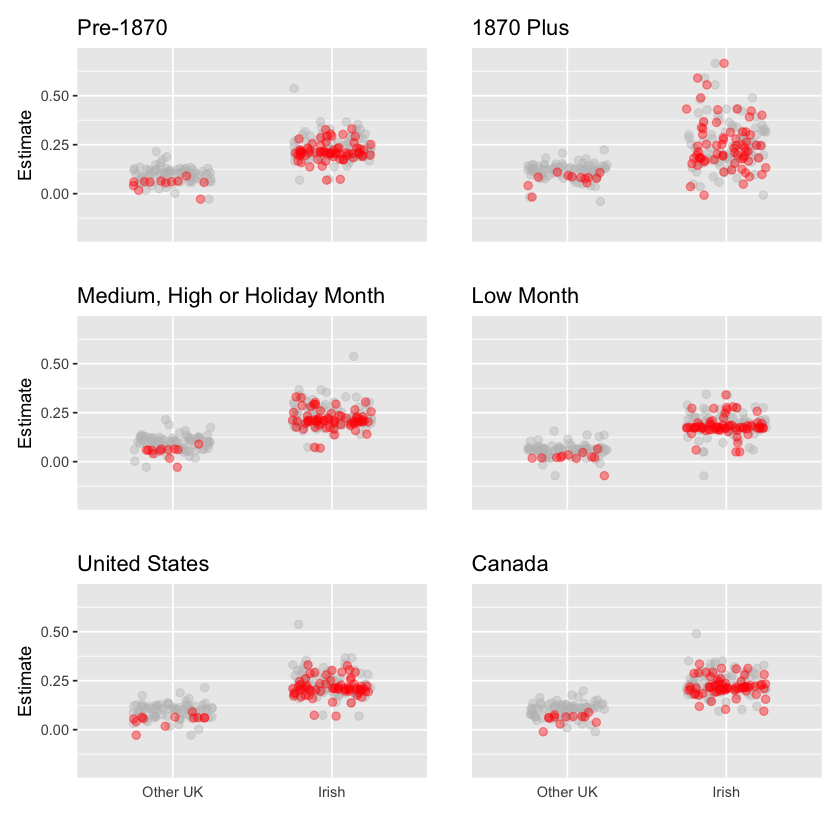

In [15]:
set.seed(5)

docids <- df %>% distinct(docauthorid, Female, Irish) %>% slice(rep(1:n(), each = 8)) %>% arrange(docauthorid)
temps <- expand_grid(lateCentury = 0:1, Canada = 0:1, lowMonths = 0:1) %>% data.frame()
nd <- cbind(docids, temps)

f <- fitted(f5ppSFILClMsIS,
         newdata = nd,
         probs = c(.05, .95)) %>% 
         data.frame() %>% 
         bind_cols(nd)

p <- f %>%filter(lateCentury == 0 & Canada == 0 & lowMonths == 0)

p0 <- p %>% ggplot( aes(x=factor(Irish), y=Estimate, group=factor(docauthorid), color=factor(Female))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank())+
ylim(-.2, .7)+
ggtitle("Pre-1870")+
gghighlight(Female == 1)

p <- f %>%filter(lateCentury == 1 & Canada == 0 & lowMonths == 0)

p1 <- p %>% ggplot( aes(x=factor(Irish), y=Estimate, group=factor(docauthorid), color=factor(Female))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank(), , axis.text.x = element_blank())+
ylim(-.2, .7)+
ggtitle("1870 Plus")+
ylab("")+
gghighlight(Female == 1)

p <- f %>%filter(lateCentury == 0 & Canada == 0 & lowMonths == 0)

p3 <- p %>% ggplot( aes(x=factor(Irish), y=Estimate, group=factor(docauthorid), color=factor(Female))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank())+
ylim(-.2, .7)+
ggtitle("Medium, High or Holiday Month")+
gghighlight(Female == 1)

p <- f %>%filter(lateCentury == 0 & Canada == 0 & lowMonths == 1)

p4 <- p %>% ggplot( aes(x=factor(Irish), y=Estimate, group=factor(docauthorid), color=factor(Female))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank(), , axis.text.x = element_blank())+
ylim(-.2, .7)+
ggtitle("Low Month")+
ylab("")+
gghighlight(Female == 1)

p <- f %>%filter(lateCentury == 0 & Canada == 0 & lowMonths == 0)

p5 <- p %>% ggplot( aes(x=factor(Irish), y=Estimate, group=factor(docauthorid), color=factor(Female))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank())+
ylim(-.2, .7)+
ggtitle("United States")+
gghighlight(Female == 1)

p <- f %>%filter(lateCentury == 0 & Canada == 1 & lowMonths == 0)

p6 <- p %>% ggplot( aes(x=factor(Irish), y=Estimate, group=factor(docauthorid), color=factor(Female))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank())+
ylim(-.2, .7)+
ggtitle("Canada")+
ylab("")+
gghighlight(Female == 1)

(p0 & p1) / (p3 & p4) / (p5 & p6)

#ggsave("20250403_PhD_GenderRandoms.jpg")

In [41]:
counts <- df %>% 
group_by(docauthorid) %>% 
count() %>%
arrange(desc(n))

# High representation
idsHigh <- counts %>% 
filter (n >= 10) %>%
pull(docauthorid) 

# Average representation (better phrased as medium representation)
idsAve <- counts %>% 
filter (n >= 3 & n<=9) %>%
pull(docauthorid) 

# Low representation
idsLow <- counts %>% 
filter (n >= 1 & n<=2) %>%
pull(docauthorid)

prolifics <- c("per0038009", "per0004772", "IED0661")

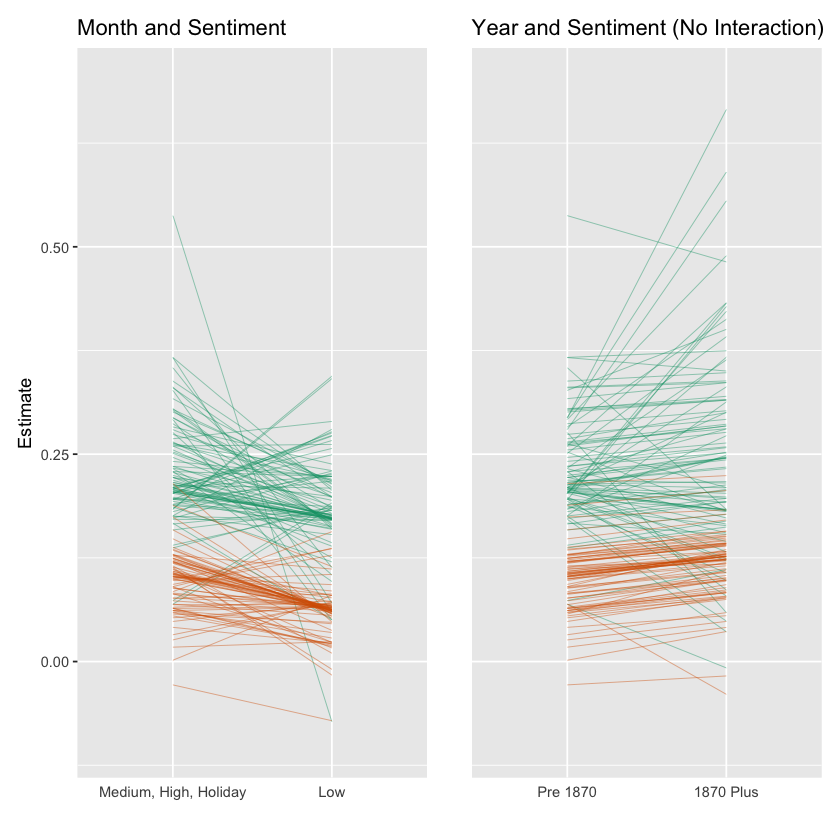

In [32]:
p <- f %>%filter(lateCentury == 0 & Canada == 0)
#p$Gender[p$Female==0]<-"Male"
#p$Gender[p$Female==1]<-"Female"
p$Origin[p$Irish==0]<-"Other UK"
p$Origin[p$Irish==1]<-"Irish"

p1 <- p %>% ggplot( aes(x=factor(lowMonths), y=Estimate, group=factor(docauthorid), color=factor(Origin))) +
    geom_line(alpha = .6, size = .2)+
  scale_x_discrete(labels=c("0" = "Medium, High, Holiday", "1" = "Low"))+
xlab("")+ 
scale_color_manual(values = c("#009E73", "#D55E00"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank())+
ylim(-.1, .7)+
ggtitle("Month and Sentiment")#+
#gghighlight(docauthorid %in% idsLow)

p <- f %>%filter(lowMonths == 0 & Canada == 0)
#p$Gender[p$Female==0]<-"Male"
#p$Gender[p$Female==1]<-"Female"
p$Origin[p$Irish==0]<-"Other UK"
p$Origin[p$Irish==1]<-"Irish"

p2 <- p %>% ggplot( aes(x=factor(lateCentury), y=Estimate, group=factor(docauthorid), color=factor(Origin))) +
    geom_line(alpha = .6, size = .2)+
  scale_x_discrete(labels=c("0" = "Pre 1870", "1" = "1870 Plus"))+
xlab("")+ 
scale_color_manual(values = c("#009E73", "#D55E00"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank())+
ylim(-.1, .7)+
ggtitle("Year and Sentiment (No Interaction)")+
ylab("")#+
#gghighlight(docauthorid %in% idsLow)

p1 & p2

#ggsave("20250403_PhD_TextControlRandoms.jpg")

In [482]:
p <- f %>%filter(lowMonths == 0 & Canada == 0)
p %>% filter(lateCentury == 0) %>% pull(Estimate) %>% sd()
p %>% filter(lateCentury == 1) %>% pull(Estimate) %>% sd()


[1] 0.08661611

[1] 0.1142823

In [481]:
p <- f %>%filter(lateCentury == 0 & Canada == 0)
p %>% filter(lowMonths == 0) %>% pull(Estimate) %>% sd()
p %>% filter(lowMonths == 1) %>% pull(Estimate) %>% sd()

[1] 0.08661611

[1] 0.0797542

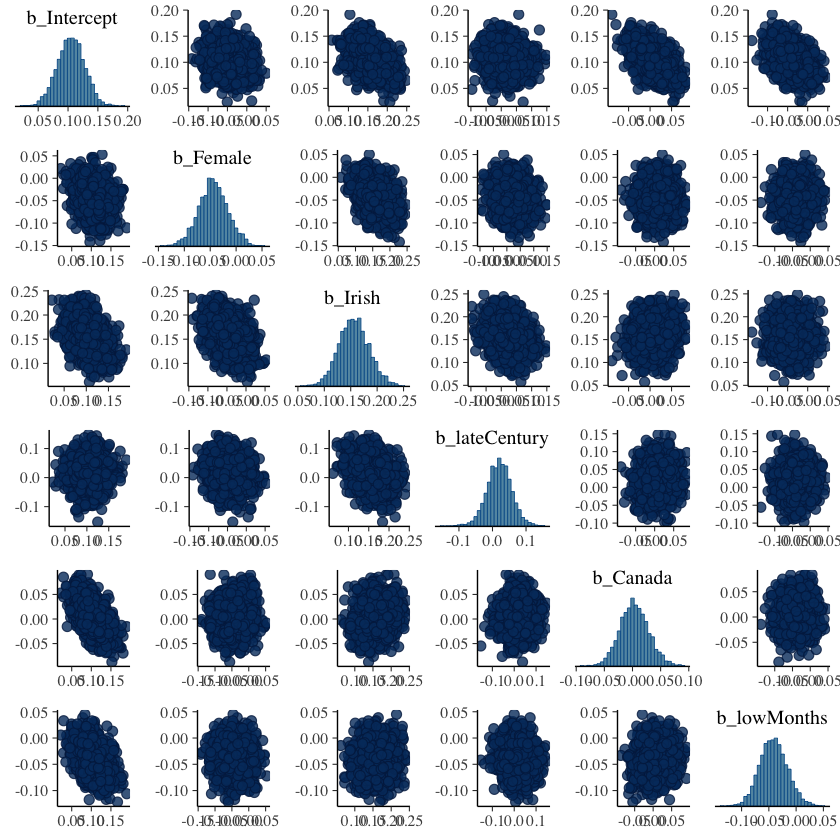

In [121]:
pairs(f5ppSFILClMsIS, variable = "^b_", regex = TRUE)

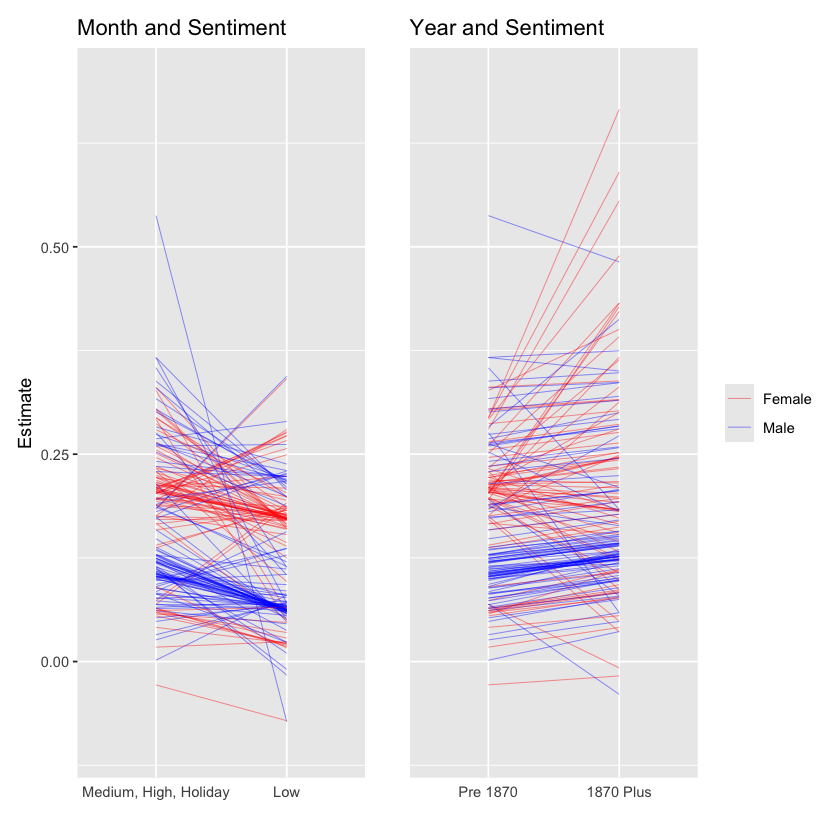

In [495]:
p <- f %>%filter(lateCentury == 0 & Canada == 0)
p$Gender[p$Female==0]<-"Male"
p$Gender[p$Female==1]<-"Female"

p1 <- p %>% ggplot( aes(x=factor(lowMonths), y=Estimate, group=factor(docauthorid), color=factor(Gender))) +
    geom_line(alpha = .6, size = .2)+
  scale_x_discrete(labels=c("0" = "Medium, High, Holiday", "1" = "Low"))+
xlab("")+ 
scale_color_manual(values = c("red", "blue"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank())+
ylim(-.1, .7)+
ggtitle("Month and Sentiment")#+
#gghighlight(docauthorid %in% prolifics)

p <- f %>%filter(lowMonths == 0 & Canada == 0)
p$Gender[p$Female==0]<-"Male"
p$Gender[p$Female==1]<-"Female"

p2 <- p %>% ggplot( aes(x=factor(lateCentury), y=Estimate, group=factor(docauthorid), color=factor(Gender))) +
    geom_line(alpha = .6, size = .2)+
  scale_x_discrete(labels=c("0" = "Pre 1870", "1" = "1870 Plus"))+
xlab("")+ 
scale_color_manual(values = c("red", "blue"))+
theme(legend.position = "right", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank())+
ylim(-.1, .7)+
ggtitle("Year and Sentiment")+
ylab("")#+
#gghighlight(docauthorid %in% prolifics)

p1 & p2

#ggsave("20250403_PhD_TextControlRandoms.jpg")

## Adding a 2nd level variable (National Origin) on the relationship between Year and Compound Sentiment 

$$CompoundSentiment_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$

$$\mu_{ik} = \beta_{0k} + \beta_{1k}Year_i + \beta_{2k}Month_i + \beta_{3k}Place_i $$

$$\beta_{0k} = \gamma_{00} + \gamma_{01}Origin_k + \gamma_{02}Gender_k + \eta_{0k}$$ 
$$\beta_{1k} = \gamma_{10} + \gamma_{11}Origin_k + \eta_{1k}$$
$$\beta_{2k} = \gamma_{20} + \eta_{2k}$$
$$\beta_{3k} = \gamma_{30} + \eta_{3k}$$
$$\gamma_{00},...,\gamma_{30} \sim \mathrm{Normal}(0,.2)$$
$$\sigma \sim \mathrm{Uniform}(0,.3)$$ 

$$\left[ \begin{split}\eta_{0k} \\ \eta_{1k} \\ \eta_{2k} \\ \eta_{3k}\end{split} \right] \sim \mathrm{MVNormal}\left(\left[ \begin{split}0 \\ 0\\ 0 \\ 0 \end{split} \right], \Phi R \Phi\right)$$

$$\Phi = \begin{bmatrix}\phi_0&0&0&0 \\ 0&\phi_1&0&0 \\ 0&0&\phi_2&0 \\ 0&0&0&\phi_3 \end{bmatrix}$$

$$\mathrm{R} = \begin{bmatrix}1&\rho_{01}&\rho_{02}&\rho_{03}\\ {\color{grey}\rho_{\color{grey}{01}}}&1&\rho_{12}&\rho_{13}\\ {\color{grey}\rho_{\color{grey}{02}}}& {\color{grey}\rho_{\color{grey}{12}}}&1&\rho_{23}\\  {\color{grey}\rho_{\color{grey}{03}}}&{\color{grey}\rho_{\color{grey}{13}}}&{\color{grey}\rho_{\color{grey}{23}}}&1\end{bmatrix}$$

$$\phi_0, \phi_1, \phi_2, \phi_3 \sim \mathrm{Uniform}(0,.3) $$
$$R \sim \mathrm{LKJ}(2)$$


20190228_PM_Slides.pdf<br>soci620_19_randomIntercepts.pdf

In [122]:
#get_prior(data=df, family = 'gaussian', formula = scoreCom ~ 1 + Female + Irish * lateCentury + Canada + lowMonths + 
#(1 + lateCentury + Canada + lowMonths | docauthorid))

f5ppSFIxLClMsIS <- readRDS("20250403_PhD_LtrChkScoCom-ppSFIxLClMsIS.rds")

#f5ppSFIxLClMsIS <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + Female + Irish * lateCentury + Canada + lowMonths + 
#(1 + lateCentury + Canada + lowMonths | docauthorid),
#                    prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma_00
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), # phi_0, phi_1, phi_2, phi_3
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
#                    set_prior("normal(0,.2)",class='b'), # default prior for coefficients
#                    set_prior("lkj(2)", class = "cor")), # R 
#            iter=2500, warmup = 1500, chains=4, cores=4, seed = 4,
#            file = "20250403_PhD_LtrChkScoCom-ppSFIxLClMsIS",
#          control=list(adapt_delta=.99))

#prior_summary(f5ppSFIxLClMsIS)
print(f5ppSFIxLClMsIS)
#posterior_summary(f5ppSFIxLClMsIS, probs = c(.05, .95))[1:6,] #90% CI
#posterior_summary(f5ppSFIxLClMsIS, probs = c(.15, .85))[1:6,] #70% CI

#20190326_PM_Code.html

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + Female + Irish * lateCentury + Canada + lowMonths + (1 + lateCentury + Canada + lowMonths | docauthorid) 
   Data: df (Number of observations: 2364) 
  Draws: 4 chains, each with iter = 2500; warmup = 1500; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                  0.10      0.02     0.07     0.13 1.00     1852
sd(lateCentury)                0.19      0.04     0.10     0.28 1.00      655
sd(Canada)                     0.05      0.04     0.00     0.13 1.00      601
sd(lowMonths)                  0.16      0.03     0.12     0.21 1.00     1691
cor(Intercept,lateCentury)    -0.03      0.30    -0.59     0.58 1.00      448
cor(Intercept,Canada)         -0.21      0.36    -0.78     0.57 1.00     1318
cor(lateCentury,Canada)        0.09      0.36

In [21]:
# Fixed Effects

fe90 <- fixef(f5ppSFIxLClMsIS, probs = c(.05,.95))
fe70 <- fixef(f5ppSFIxLClMsIS, probs = c(.15,.85))

temp <- data.frame(round(fe90, digits=3))
cbind(temp, round(fe70[,3:4], digits = 3)) %>% rename(Lower90 = Q5, Upper90 = Q95, Lower70 = Q15, Upper70 = Q85)%>%
mutate(Parameter = c("Intercept", "Gender: Female", "Origin: Irish", "Year: After 1869", "Place: Canada", "Month: Jan, Feb, Jul, Aug", "Irish + After 1869")) %>%
remove_rownames() %>%
column_to_rownames("Parameter")%>%
mutate(across(1:6, round, 3))


Estimate Est.Error Lower90 Upper90 Lower70 Upper70
Intercept                  0.106   0.023      0.068  0.143    0.082   0.130 
Gender: Female            -0.046   0.029     -0.093  0.001   -0.076  -0.017 
Origin: Irish              0.155   0.028      0.112  0.202    0.126   0.184 
Year: After 1869          -0.017   0.099     -0.182  0.144   -0.117   0.082 
Place: Canada              0.003   0.026     -0.038  0.047   -0.024   0.030 
Month: Jan, Feb, Jul, Aug -0.040   0.025     -0.080  0.001   -0.066  -0.015 
Irish + After 1869         0.044   0.102     -0.121  0.213   -0.060   0.149

In [22]:
round(fixef(f5ppSFIxLClMsIS, probs = c(.05,.95))[4, 1] + fixef(f5ppSFIxLClMsIS, probs = c(.05,.95))[7, 1] * 0, 3) # Not Irish, after 1869
round(fixef(f5ppSFIxLClMsIS, probs = c(.05,.95))[4, 1] + fixef(f5ppSFIxLClMsIS, probs = c(.05,.95))[7, 1] * 1, 3) # Irish, after 1869

[1] -0.017

[1] 0.027

In [59]:
post <- as_draws_df(f5ppSFIxLClMsIS) %>% data.frame()

post %>%
  transmute(Irish    = b_lateCentury + b_Irish.lateCentury * 1,
            OtherUK = b_lateCentury + b_Irish.lateCentury * 0) %>%
  gather(key, value) %>%
  group_by(key) %>%
  summarise(mean = mean(value))

key     mean       
1 Irish    0.02698248
2 OtherUK -0.01695416

Picking joint bandwidth of 0.0118

Saving 7 x 7 in image
Picking joint bandwidth of 0.0118



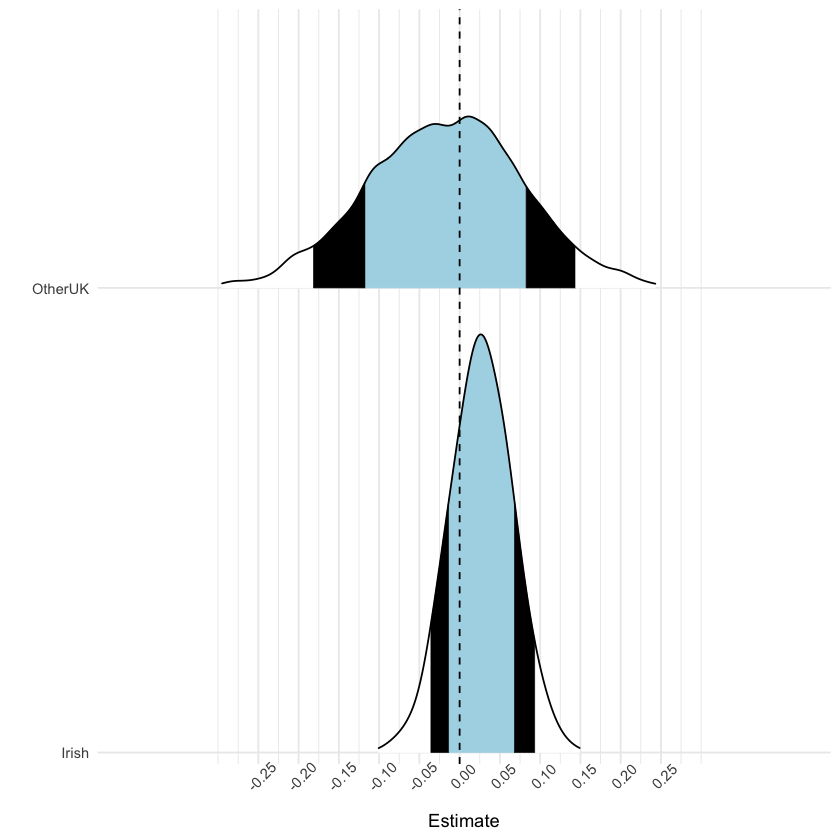

In [119]:
post %>%
  transmute(Irish    = b_lateCentury + b_Irish.lateCentury * 1,
            OtherUK = b_lateCentury + b_Irish.lateCentury * 0) %>%
  gather(key, value)%>%

# Highlight the tails of the distributions
ggplot(aes(x = value, y = key, fill = factor(stat(quantile)))) +
  stat_density_ridges(
    geom = "density_ridges_gradient",
    calc_ecdf = TRUE,
    quantiles = c(0.05,0.15,0.50,0.85,0.95), alpha = 0.5, scale = .9, rel_min_height = 0.01
  ) +
  scale_fill_manual(
    name = "Credible Intervals", values = c("#FFFFFF", "#000000", "lightblue", "lightblue", "#000000", "#FFFFFF"),
    labels = c("(0, 0.05]", "(0.05, 0.15]", "(0.15, 0.50]", "(0.50, 0.85]", "(0.85, 0.95]", "(0.95, 1]")
  )+ 
ylab("")+
xlab("Estimate")+
theme_minimal()+
theme(legend.position = "none", axis.text.x = element_text(angle=45))+
scale_x_continuous(breaks = seq(-0.25, 0.25, by = .05))+
scale_y_discrete(expand = expansion(add = c(0.025, 0.6)))+
geom_vline(xintercept = 0, linetype=2)

ggsave("20250407_PhD_YeaSenOriInt-CC.jpg")

In [34]:
set.seed(5)

docids <- df %>% distinct(docauthorid, Female, Irish) %>% slice(rep(1:n(), each = 8)) %>% arrange(docauthorid)
temps <- expand_grid(lateCentury = 0:1, Canada = 0:1, lowMonths = 0:1) %>% data.frame()
nd <- cbind(docids, temps)

f <- fitted(f5ppSFIxLClMsIS,
         newdata = nd,
         probs = c(.05, .95)) %>% 
         data.frame() %>% 
         bind_cols(nd)

Saving 7 x 7 in image


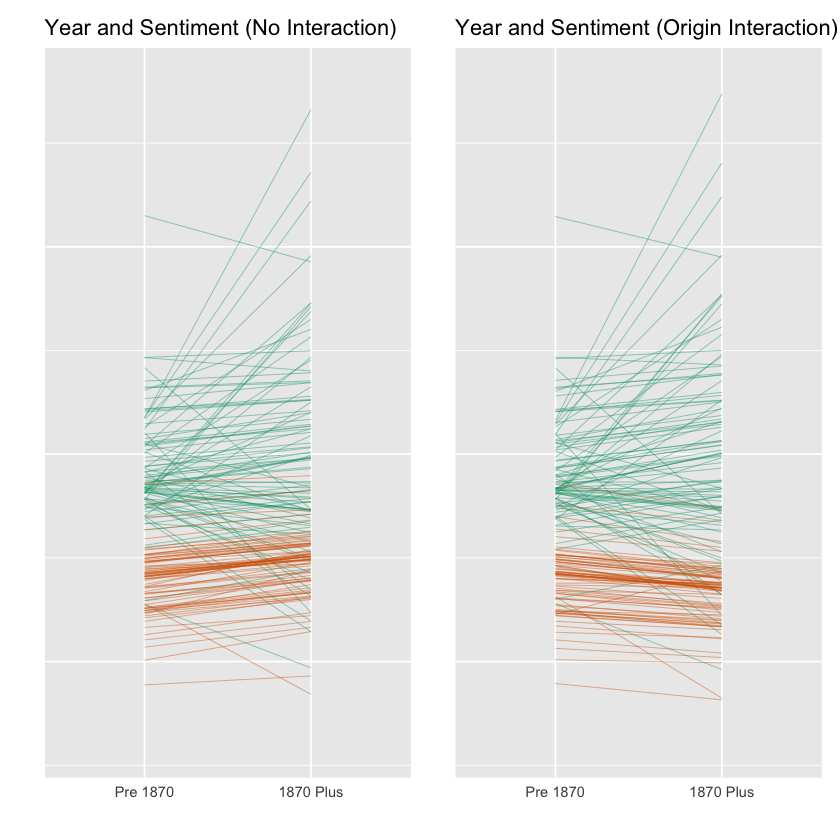

In [36]:
p <- f %>%filter(lowMonths == 0 & Canada == 0)
#p$Gender[p$Female==0]<-"Male"
#p$Gender[p$Female==1]<-"Female"
p$Origin[p$Irish==0]<-"Other UK"
p$Origin[p$Irish==1]<-"Irish"

p3 <- p %>% ggplot( aes(x=factor(lateCentury), y=Estimate, group=factor(docauthorid), color=factor(Origin))) +
    geom_line(alpha = .6, size = .2)+
  scale_x_discrete(labels=c("0" = "Pre 1870", "1" = "1870 Plus"))+
xlab("")+ 
scale_color_manual(values = c("#009E73", "#D55E00"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank())+
ylim(-.1, .7)+
ggtitle("Year and Sentiment (Origin Interaction)")+
ylab("")#+
#gghighlight(docauthorid %in% idsLow)

p2 & p3

ggsave("20250407_PhD_YeaSenInter.jpg")

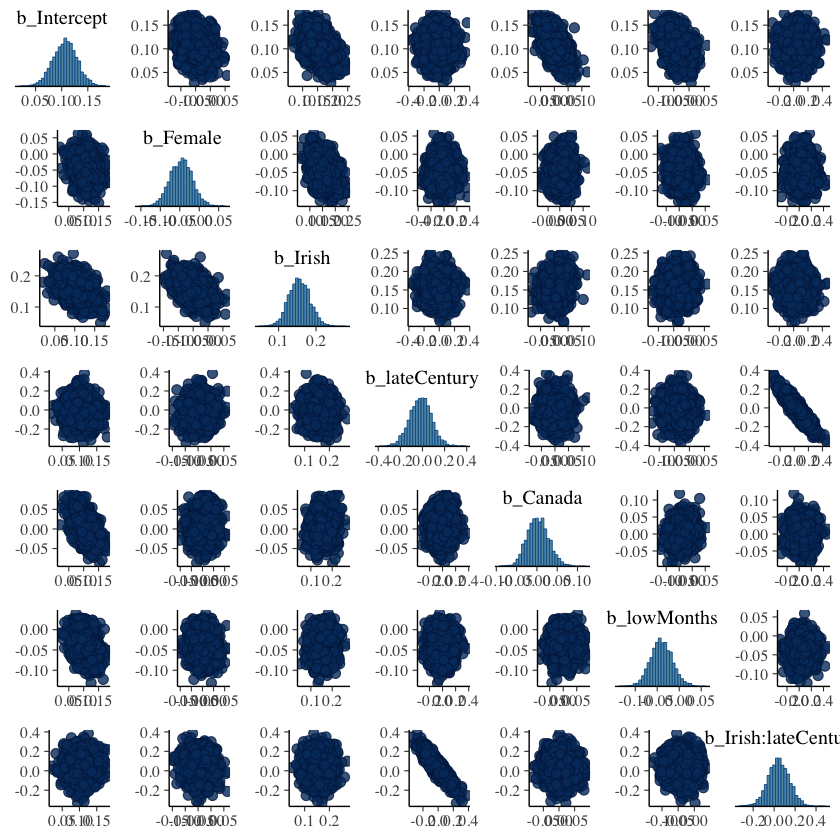

In [124]:
pairs(f5ppSFIxLClMsIS, variable = "^b_", regex = TRUE)
# See page 299 in Chapter 10 McElreath (2015) and vis for pairs plots for models b10.3 and b10.9 at https://bookdown.org/content/3890/counting-and-classification.html

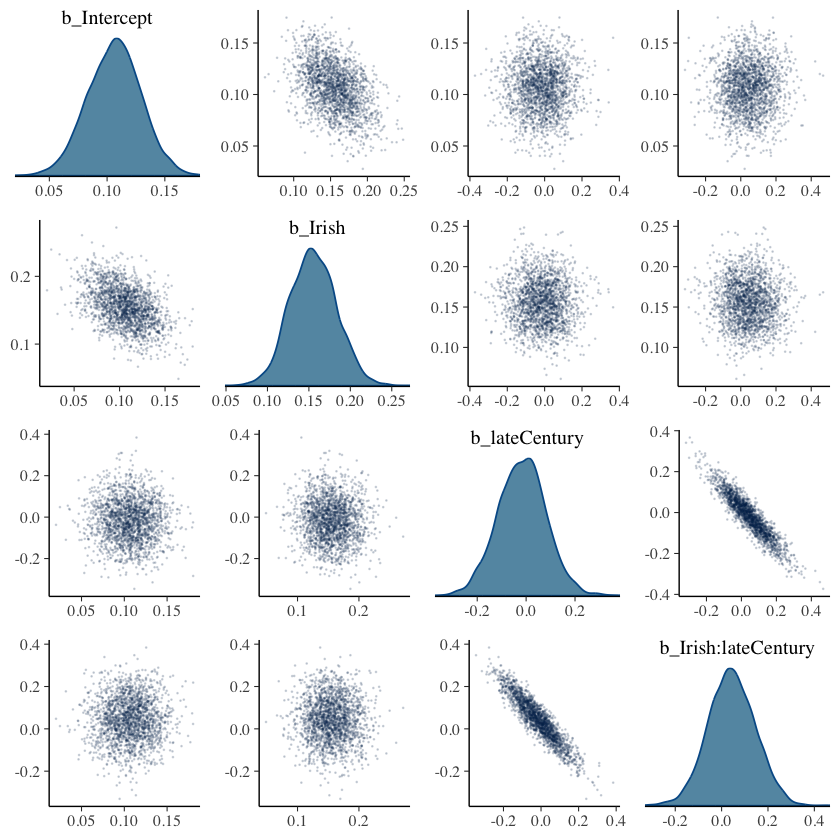

In [129]:
mcmc_pairs(x = as_draws_df(f5ppSFIxLClMsIS),
           pars = vars(c("b_Intercept", "b_Irish", "b_lateCentury", "b_Irish:lateCentury")),
           off_diag_args = list(size = 1/10, alpha = 1/6),
           diag_fun = "dens")

In [259]:
# Compare Models
f5ppS_i <- add_criterion(f5ppS, "waic")
f5ppSFILClMs_i <- add_criterion(f5ppSFILClMs, "waic")
f5ppSFILClMsIS_i <- add_criterion(f5ppSFILClMsIS, "waic")
f5ppSFIxLClMsIS_i <- add_criterion(f5ppSFIxLClMsIS, "waic")

w <- loo_compare(f5ppS_i, f5ppSFILClMs_i, f5ppSFILClMsIS_i, f5ppSFIxLClMsIS_i, criterion = "waic")

print(w, simplify = F)

                  elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic
f5ppSFIxLClMsIS_i    0.0       0.0  -266.5      72.2        147.5   10.2   
f5ppSFILClMsIS_i    -0.6       0.6  -267.1      72.1        147.8   10.3   
f5ppSFILClMs_i     -42.6      18.0  -309.1      68.6        108.3    7.7   
f5ppS_i            -56.5      19.8  -323.0      68.2        115.9    8.2   
                  waic   se_waic
f5ppSFIxLClMsIS_i  533.0  144.5 
f5ppSFILClMsIS_i   534.1  144.2 
f5ppSFILClMs_i     618.3  137.1 
f5ppS_i            645.9  136.4 


In [261]:
wDF <- w %>% 
as.data.frame() %>% 
mutate(model = c("Multivariate, Random Intercepts & Slopes, 2nd Level Predictor",
                 "Multivariate, Random Intercepts & Slopes", 
                 "Multivariate, Random Intercepts", 
                 "Univariate, Random Intercepts")) %>% 
remove_rownames() %>%
column_to_rownames("model")%>%
select(waic, elpd_diff, se_diff)%>%
rename("WAIC" = 1, "Elapsed Difference" = 2, "Standard Error" = 3)%>%
mutate(across(1:3, round, 2))

wDF
#print(round(wDF, 2))

WAIC  
Multivariate, Random Intercepts & Slopes, 2nd Level Predictor 532.98
Multivariate, Random Intercepts & Slopes                      534.14
Multivariate, Random Intercepts                               618.27
Univariate, Random Intercepts                                 645.95
                                                              Elapsed Difference
Multivariate, Random Intercepts & Slopes, 2nd Level Predictor   0.00            
Multivariate, Random Intercepts & Slopes                       -0.58            
Multivariate, Random Intercepts                               -42.65            
Univariate, Random Intercepts                                 -56.48            
                                                              Standard Error
Multivariate, Random Intercepts & Slopes, 2nd Level Predictor  0.00         
Multivariate, Random Intercepts & Slopes                       0.58         
Multivariate, Random Intercepts                               17.95         
Univariate, Random Intercepts                                 19.77

## Changing Dummy Variables to Factor for Vis

In [38]:
df$FemaleF <- factor(df$Female)
df$IrishF <- factor(df$Irish)
df$CanadaF <- factor(df$Canada)
df$lateCenturyF <- factor(df$lateCentury)
df$lowMonthsF <- factor(df$lowMonths)

In [39]:
#get_prior(data=df, family = 'gaussian', formula = scoreCom ~ 1 + Female + Irish * lateCentury + Canada + lowMonths + 
#(1 + lateCentury + Canada + lowMonths | docauthorid))

f5ppSFIxLClMsIS <- readRDS("20250407_PhD_LtrChkScoCom-ppSFIxLClMsIS.rds")

#f5ppSFIxLClMsIS <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + FemaleF + IrishF * lateCenturyF + CanadaF + lowMonthsF + 
#(1 + lateCenturyF + CanadaF + lowMonthsF | docauthorid),
#                    prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma_00
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), # phi_0, phi_1, phi_2, phi_3
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3), #sigma
#                    set_prior("normal(0,.2)",class='b'), # default prior for coefficients
#                    set_prior("lkj(2)", class = "cor")), # R 
#            iter=2500, warmup = 1500, chains=4, cores=4, seed = 4,
#            file = "20250407_PhD_LtrChkScoCom-ppSFIxLClMsIS",
#          control=list(adapt_delta=.99))

#prior_summary(f5ppSFIxLClMsIS)
print(f5ppSFIxLClMsIS)
#posterior_summary(f5ppSFIxLClMsIS, probs = c(.05, .95))[1:6,] #90% CI
#posterior_summary(f5ppSFIxLClMsIS, probs = c(.15, .85))[1:6,] #70% CI

#20190326_PM_Code.html

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + FemaleF + IrishF * lateCenturyF + CanadaF + lowMonthsF + (1 + lateCenturyF + CanadaF + lowMonthsF | docauthorid) 
   Data: df (Number of observations: 2364) 
  Draws: 4 chains, each with iter = 2500; warmup = 1500; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
                               Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                      0.10      0.02     0.07     0.13 1.00
sd(lateCenturyF1)                  0.19      0.04     0.10     0.28 1.00
sd(CanadaF1)                       0.05      0.04     0.00     0.13 1.00
sd(lowMonthsF1)                    0.16      0.03     0.12     0.21 1.00
cor(Intercept,lateCenturyF1)      -0.03      0.30    -0.59     0.58 1.00
cor(Intercept,CanadaF1)           -0.21      0.36    -0.78     0.57 1.00
cor(lateCenturyF1,CanadaF1)        0.09      0.36    -0.63     0.75 1.00

In [272]:
# Fixed Effects

fe90 <- fixef(f5ppSFIxLClMsIS, probs = c(.05,.95))
fe70 <- fixef(f5ppSFIxLClMsIS, probs = c(.15,.85))

temp <- data.frame(round(fe90, digits=3))
cbind(temp, round(fe70[,3:4], digits = 3)) %>% rename(Lower90 = Q5, Upper90 = Q95, Lower70 = Q15, Upper70 = Q85)%>%
mutate(Parameter = c("Intercept", "Gender: Female", "Origin: Irish", "Year: After 1869", "Place: Canada", "Month: Jan, Feb, Jul, Aug", "Irish + After 1869")) %>%
remove_rownames() %>%
column_to_rownames("Parameter")%>%
mutate(across(1:6, round, 3))


Estimate Est.Error Lower90 Upper90 Lower70 Upper70
Intercept                  0.106   0.023      0.068  0.143    0.082   0.130 
Gender: Female            -0.046   0.029     -0.093  0.001   -0.076  -0.017 
Origin: Irish              0.155   0.028      0.112  0.202    0.126   0.184 
Year: After 1869          -0.017   0.099     -0.182  0.144   -0.117   0.082 
Place: Canada              0.003   0.026     -0.038  0.047   -0.024   0.030 
Month: Jan, Feb, Jul, Aug -0.040   0.025     -0.080  0.001   -0.066  -0.015 
Irish + After 1869         0.044   0.102     -0.121  0.213   -0.060   0.149

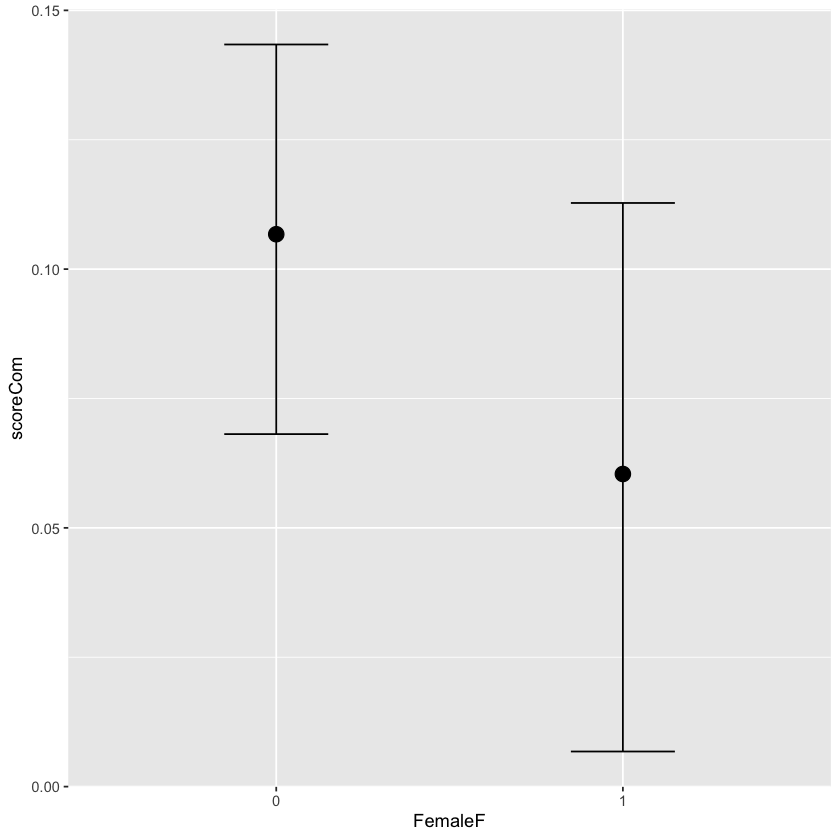

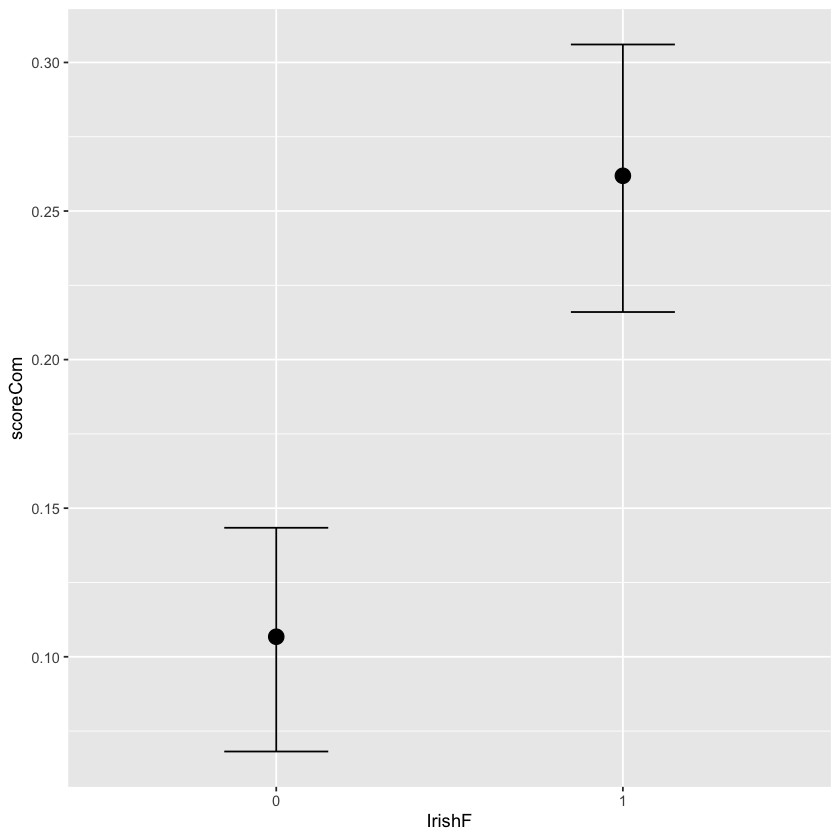

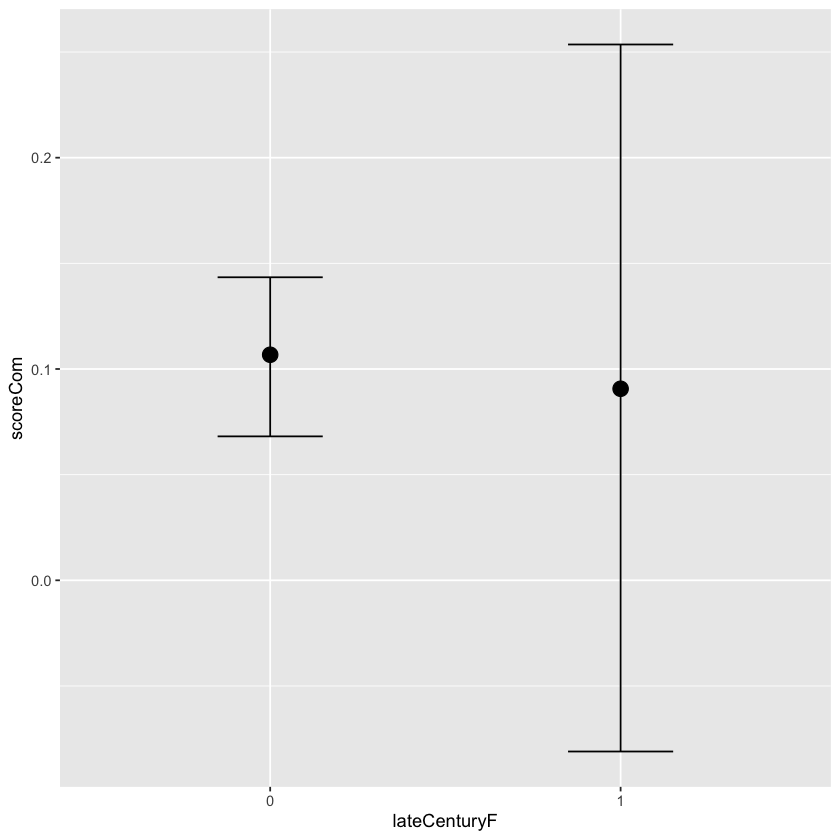

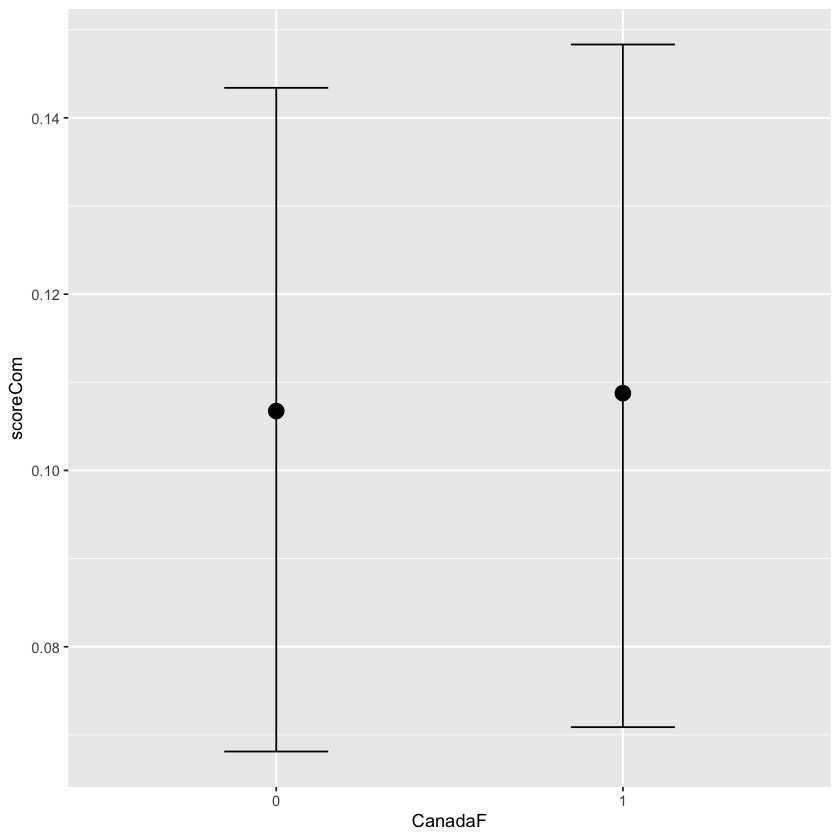

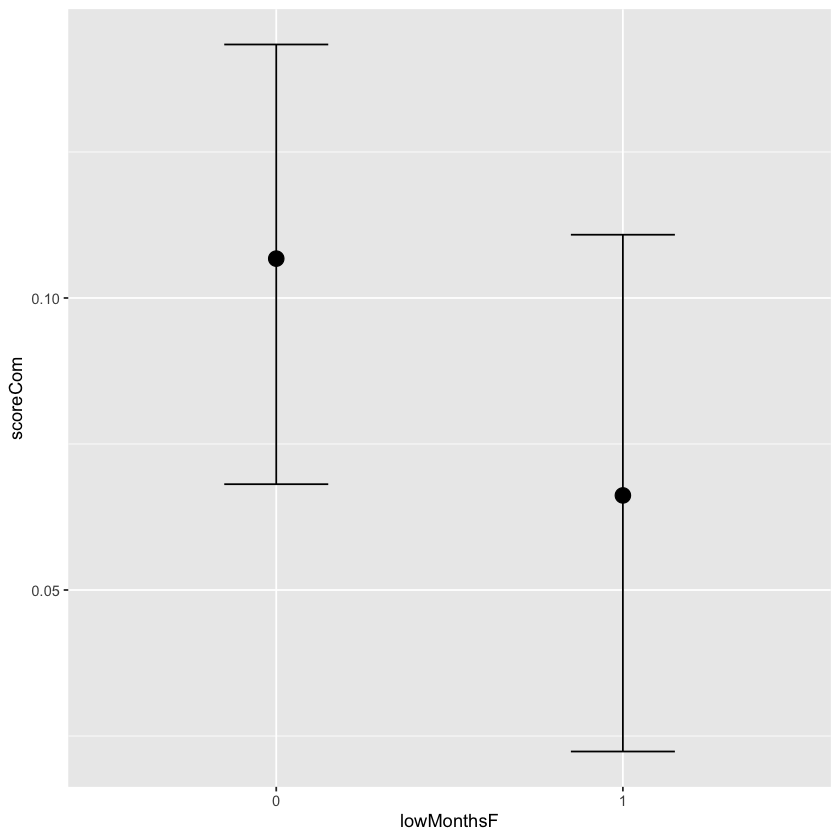

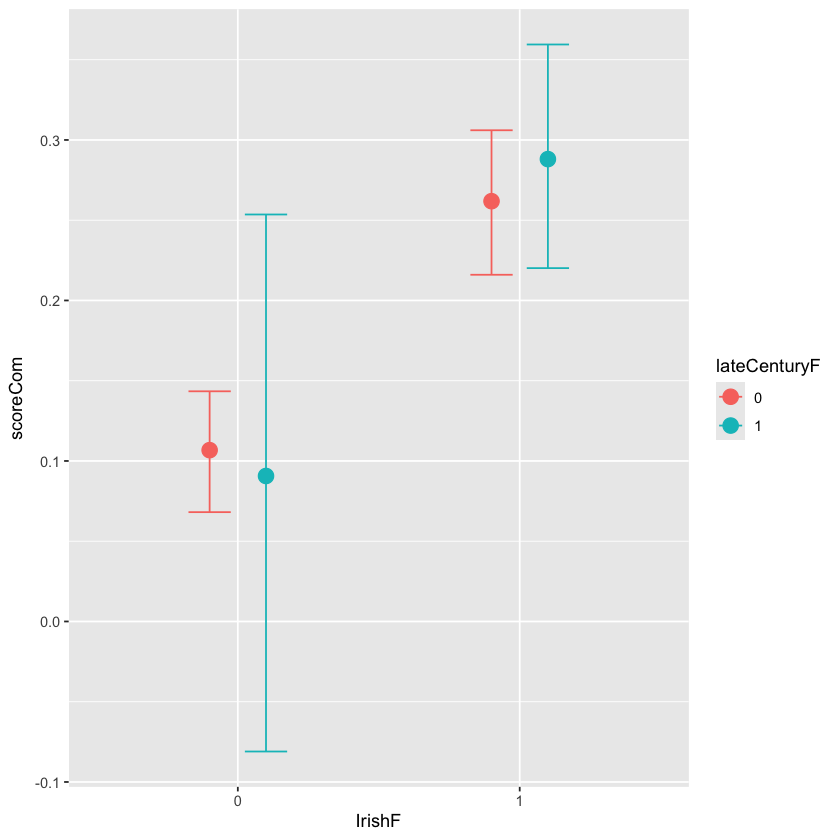

In [273]:
conditional_effects(f5ppSFIxLClMsIS, prob = .90)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Saving 7 x 7 in image


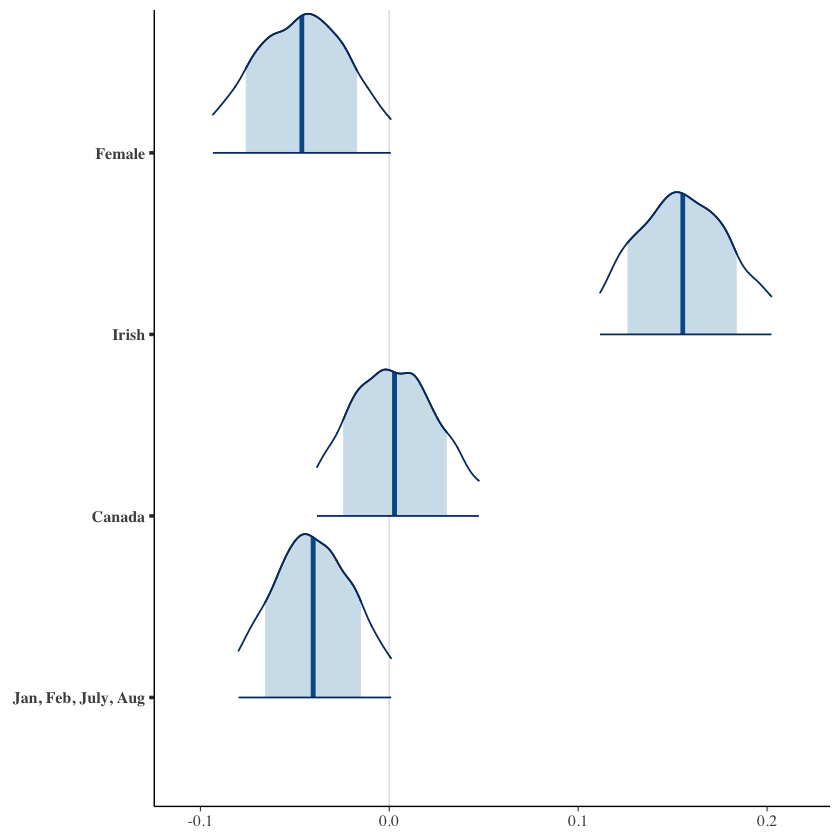

In [291]:
#mcmc_plot(f3_valTopSWB_mis, variable = "^b_", regex = TRUE, prob = 0.7, prob_outer = 0.9, outer_size = 0.5)
p <- mcmc_areas(f5ppSFIxLClMsIS, pars = c("b_lowMonthsF1", 
                                          "b_CanadaF1", 
                                          "b_IrishF1", 
                                          "b_FemaleF1"), 
                prob = 0.7, prob_outer = 0.9, point_est = "mean")
p +
scale_y_discrete(labels=c("b_lowMonthsF1" = "Jan, Feb, July, Aug", 
                          "b_CanadaF1" = "Canada", 
                          "b_FemaleF1" = "Female", 
                          "b_IrishF1" = "Irish"))
#scale_x_continuous(breaks = seq(-.1,.3, .02))

#+  geom_vline(xintercept = -0.005	)
ggsave("20250407_senDemTem-fixedCCs.jpg")

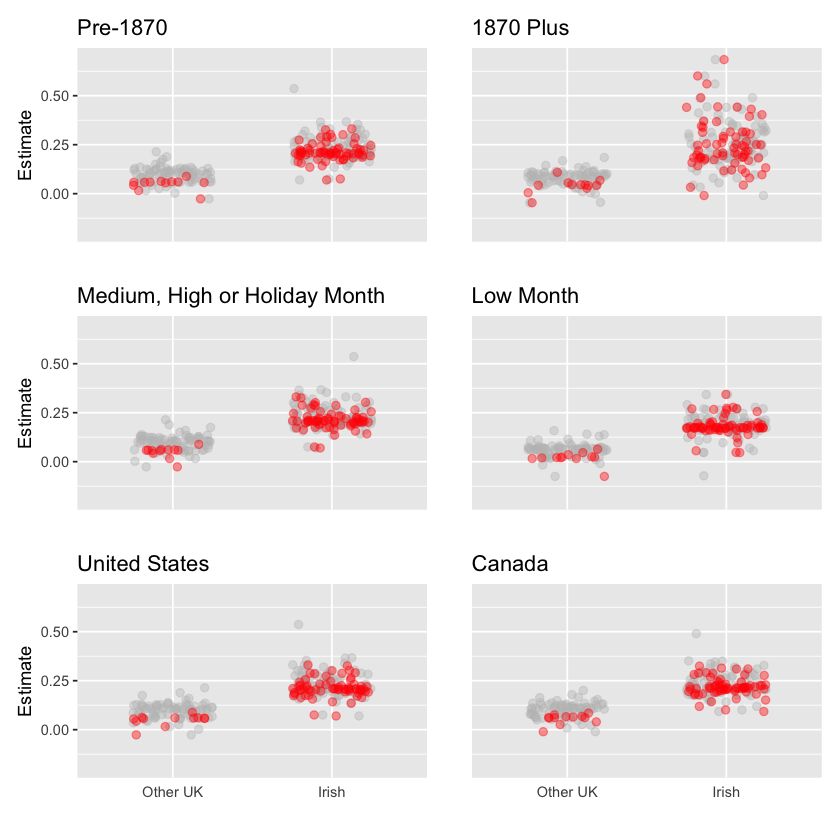

In [40]:
set.seed(5)

docids <- df %>% distinct(docauthorid, FemaleF, IrishF) %>% slice(rep(1:n(), each = 8)) %>% arrange(docauthorid)
temps <- expand_grid(lateCenturyF = 0:1, CanadaF = 0:1, lowMonthsF = 0:1) %>% data.frame()
nd <- cbind(docids, temps)

f <- fitted(f5ppSFIxLClMsIS,
         newdata = nd,
         probs = c(.05, .95)) %>% 
         data.frame() %>% 
         bind_cols(nd)

p <- f %>%filter(lateCenturyF == 0 & CanadaF == 0 & lowMonthsF == 0)

p0 <- p %>% ggplot( aes(x=factor(IrishF), y=Estimate, group=factor(docauthorid), color=factor(FemaleF))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank())+
ylim(-.2, .7)+
ggtitle("Pre-1870")+
gghighlight(FemaleF == 1)

p <- f %>%filter(lateCenturyF == 1 & CanadaF == 0 & lowMonthsF == 0)

p1 <- p %>% ggplot( aes(x=factor(IrishF), y=Estimate, group=factor(docauthorid), color=factor(FemaleF))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank(), , axis.text.x = element_blank())+
ylim(-.2, .7)+
ggtitle("1870 Plus")+
ylab("")+
gghighlight(FemaleF == 1)

p <- f %>%filter(lateCenturyF == 0 & CanadaF == 0 & lowMonthsF == 0)

p3 <- p %>% ggplot( aes(x=factor(IrishF), y=Estimate, group=factor(docauthorid), color=factor(FemaleF))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank())+
ylim(-.2, .7)+
ggtitle("Medium, High or Holiday Month")+
gghighlight(FemaleF == 1)

p <- f %>%filter(lateCenturyF == 0 & CanadaF == 0 & lowMonthsF == 1)

p4 <- p %>% ggplot( aes(x=factor(IrishF), y=Estimate, group=factor(docauthorid), color=factor(FemaleF))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank(), , axis.text.x = element_blank())+
ylim(-.2, .7)+
ggtitle("Low Month")+
ylab("")+
gghighlight(FemaleF == 1)

p <- f %>%filter(lateCenturyF == 0 & CanadaF == 0 & lowMonthsF == 0)

p5 <- p %>% ggplot( aes(x=factor(IrishF), y=Estimate, group=factor(docauthorid), color=factor(FemaleF))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank())+
ylim(-.2, .7)+
ggtitle("United States")+
gghighlight(FemaleF == 1)

p <- f %>%filter(lateCenturyF == 0 & CanadaF == 1 & lowMonthsF == 0)

p6 <- p %>% ggplot( aes(x=factor(IrishF), y=Estimate, group=factor(docauthorid), color=factor(FemaleF))) +
    #geom_line(alpha = .2, size = .4)+
geom_jitter(alpha = .4, size = 2, width = .25)+
  scale_x_discrete(labels=c("0" = "Other UK", "1" = "Irish"))+
xlab("")+ 
scale_color_manual(values = c("red"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank())+
ylim(-.2, .7)+
ggtitle("Canada")+
ylab("")+
gghighlight(FemaleF == 1)

(p0 & p1) / (p3 & p4) / (p5 & p6)

#ggsave("20250407_PhD_GenderRandoms.jpg")

Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Saving 7 x 7 in image


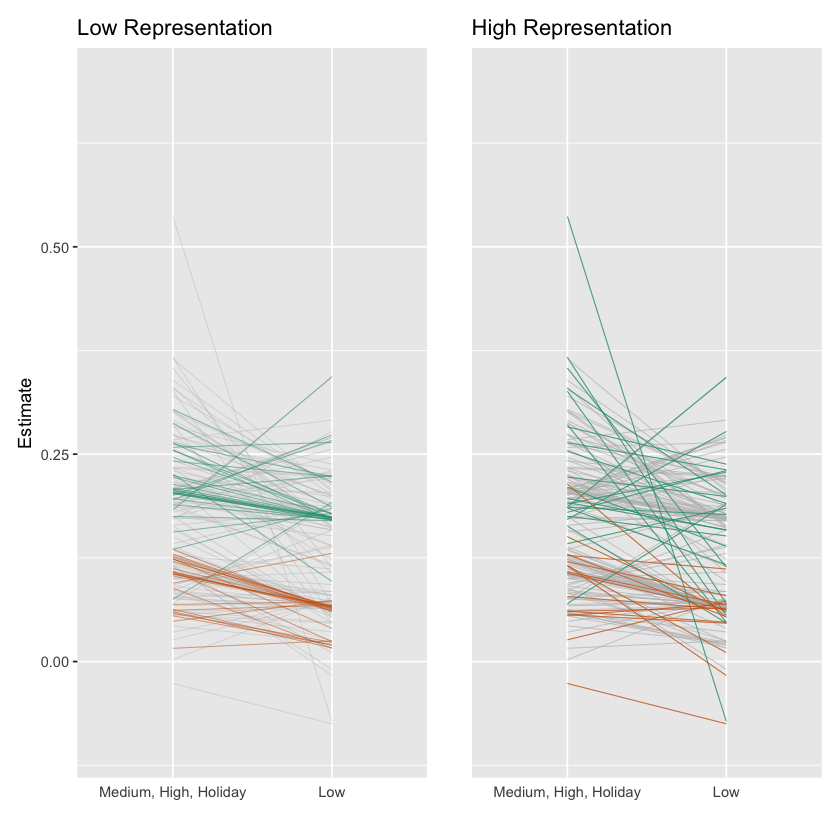

In [49]:
p <- f %>%filter(lateCenturyF == 0 & CanadaF == 0)
#p$Gender[p$Female==0]<-"Male"
#p$Gender[p$Female==1]<-"Female"
p$Origin[p$IrishF==0]<-"Other UK"
p$Origin[p$IrishF==1]<-"Irish"

p1 <- p %>% ggplot( aes(x=factor(lowMonthsF), y=Estimate, group=factor(docauthorid), color=factor(Origin))) +
    geom_line(alpha = .6, size = .2)+
  scale_x_discrete(labels=c("0" = "Medium, High, Holiday", "1" = "Low"))+
xlab("")+ 
scale_color_manual(values = c("#009E73", "#D55E00"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank())+
ylim(-.1, .7)+
ggtitle("Low Representation")+
gghighlight(docauthorid %in% idsLow)

#p <- f %>%filter(lateCenturyF == 0 & CanadaF == 0)
#p$Gender[p$Female==0]<-"Male"
#p$Gender[p$Female==1]<-"Female"
#p$Origin[p$IrishF==0]<-"Other UK"
#p$Origin[p$IrishF==1]<-"Irish"

p2 <- p %>% ggplot( aes(x=factor(lowMonthsF), y=Estimate, group=factor(docauthorid), color=factor(Origin))) +
    geom_line(alpha = 1, size = .2)+
  scale_x_discrete(labels=c("0" = "Medium, High, Holiday", "1" = "Low"))+
xlab("")+ 
scale_color_manual(values = c("#009E73", "#D55E00"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank())+
ylim(-.1, .7)+
ggtitle("High Representation")+
ylab("")+
gghighlight(docauthorid %in% idsHigh)

p1 & p2

ggsave("20250407_PhD_MonSenRep.jpg")

In [55]:
#p[p$Estimate >= .5, ]
df$authorName[df$docauthor == "IED0374"] %>% unique()

[1] Jonathan W. Smith
141 Levels: Ada C. Burns Ada C. Edgar Ada M. Demain ... William Thomas

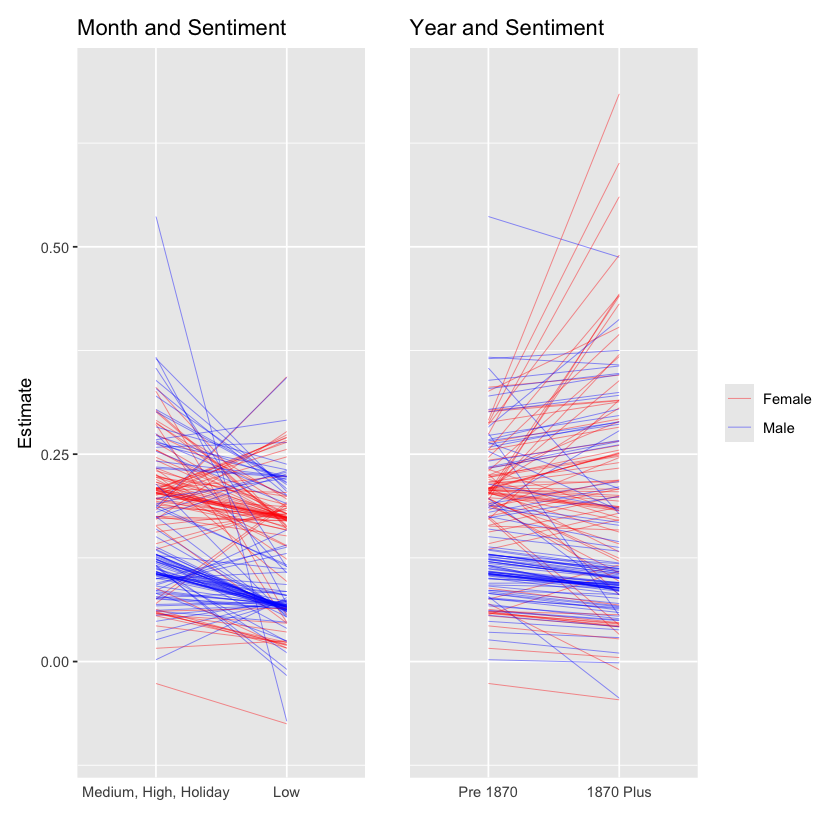

In [289]:
p <- f %>%filter(lateCenturyF == 0 & CanadaF == 0)
p$Gender[p$FemaleF==0]<-"Male"
p$Gender[p$FemaleF==1]<-"Female"

p1 <- p %>% ggplot( aes(x=factor(lowMonthsF), y=Estimate, group=factor(docauthorid), color=factor(Gender))) +
    geom_line(alpha = .6, size = .2)+
  scale_x_discrete(labels=c("0" = "Medium, High, Holiday", "1" = "Low"))+
xlab("")+ 
scale_color_manual(values = c("red", "blue"))+
theme(legend.position = "none", legend.title = element_blank(), axis.ticks.x = element_blank())+
ylim(-.1, .7)+
ggtitle("Month and Sentiment")#+
#gghighlight(docauthorid %in% prolifics)

p <- f %>%filter(lowMonthsF == 0 & CanadaF == 0)
p$Gender[p$FemaleF==0]<-"Male"
p$Gender[p$FemaleF==1]<-"Female"

p2 <- p %>% ggplot( aes(x=factor(lateCenturyF), y=Estimate, group=factor(docauthorid), color=factor(Gender))) +
    geom_line(alpha = .6, size = .2)+
  scale_x_discrete(labels=c("0" = "Pre 1870", "1" = "1870 Plus"))+
xlab("")+ 
scale_color_manual(values = c("red", "blue"))+
theme(legend.position = "right", legend.title = element_blank(), axis.ticks = element_blank(), axis.text.y = element_blank())+
ylim(-.1, .7)+
ggtitle("Year and Sentiment")+
ylab("")#+
#gghighlight(docauthorid %in% prolifics)

p1 & p2

#ggsave("20250407_PhD_TextControlRandoms.jpg")

In [290]:
glimpse(df)

Rows: 2,364
Columns: 52
$ docID.AT         <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ docid            <fct> 20910, 21062, 21062, 21324, 21334, 21334, 21354, 2135…
$ docyear          <int> 1891, 1871, 1871, 1892, 1891, 1891, 1890, 1890, 1800,…
$ docmonth         <int> 7, 11, 11, 5, 10, 10, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1…
$ authorName       <fct> Isabella Weir Moore, E. Rothwell, E. Rothwell, Isabel…
$ docauthorid      <fct> IED0107, IED0179, IED0179, IED0107, IED0621, IED0621,…
$ authorLocation   <fct> USA, Canada, Canada, USA, USA, USA, USA, USA, USA, US…
$ authorGender     <fct> F, F, F, F, F, F, M, M, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> Irish, Irish, Irish, Irish, Irish, Irish, Irish, Iris…
$ irish            <fct> True, True, True, True, True, True, True, True, True,…
$ otherUK          <fct> False, False, False, False, False, False, False, Fals…
$ relMin           <fct> NA, NA, NA, NA, False, False, NA, NA, NA, NA, NA, NA,…
$ catholic      

In [249]:
write.csv(df, "20250403_PhD_LtrChk-RQ2a.csv", row.names=FALSE)